# Installations

In [1]:
!pip install torch_geometric
!pip install torch torchvision torchaudio
!pip -q install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


# Imports

In [2]:
# Tensors and neural net functions
import torch
import torch.nn.functional as F
# GNN Layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
# Auto-downloads citation graph datasets
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.data import Data
# Math
import numpy as np
import pandas as pd
import random
import math
# Adejancy matrix
import networkx as nx
from sklearn.cluster import KMeans #  For clustering
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score # For evaluating
from __future__ import annotations

from typing import Dict, Hashable, Iterable, Optional, Tuple
from scipy.sparse import csr_matrix
from itertools import combinations
from scipy.sparse import coo_matrix, csr_matrix
from numpy.linalg import eigh # use in SpecF
from typing import List
# Plots
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# used to align cluster IDs with most common true labels
from scipy.stats import mode
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

from collections import Counter, defaultdict
from pathlib import Path
import gdown
import os, zipfile
import re
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from IPython.display import HTML, display
from collections import deque
import matplotlib.colors as mcolors

#GCN Implementation flow

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) # Aggregates 1-hop neighbors
        self.conv2 = GCNConv(hidden_channels, out_channels) # Aggregates 2-hop neighbors

    def forward(self, x, edge_index):
        # first layer
        x = self.conv1(x, edge_index)
        # non linar activation
        x = F.relu(x)
        # second layer
        x = self.conv2(x, edge_index)
        # convert embeddings into probabilities
        return F.log_softmax(x, dim=1)

# Loading PubMed & setting up training

**Unpack the ZIP files**

In [4]:
# -------------------------------------------------
# Base directories
# -------------------------------------------------
ZIP_DIR = Path("/content/Zips")
DATA_DIR = Path("/content/Data")

ZIP_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------
# Google Drive file IDs
# -------------------------------------------------
FILES = {
    "pubmed-diabetes.zip": "1W4PZ_pt8P1NwRuXogIZMxC1zneRA7zrh",
    "pubmed-new.zip": "1joaAkDL80nVNqDicWmBoCXEFccAJNTz-",
}

# -------------------------------------------------
# Download & extract
# -------------------------------------------------
for filename, file_id in FILES.items():
    zip_path = ZIP_DIR / filename

    # Download ZIP
    if not zip_path.exists():
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(zip_path), quiet=False)
    else:
        print(f"{filename} already exists.")

    # Extract into Data/
    extract_dir = DATA_DIR / filename.replace(".zip", "")
    if not extract_dir.exists():
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
        print(f"Extracted {filename} → {extract_dir}")
    else:
        print(f"{filename} already extracted.")

Downloading...
From: https://drive.google.com/uc?id=1W4PZ_pt8P1NwRuXogIZMxC1zneRA7zrh
To: /content/Zips/pubmed-diabetes.zip
100%|██████████| 14.7M/14.7M [00:00<00:00, 21.6MB/s]


Extracted pubmed-diabetes.zip → /content/Data/pubmed-diabetes


Downloading...
From: https://drive.google.com/uc?id=1joaAkDL80nVNqDicWmBoCXEFccAJNTz-
To: /content/Zips/pubmed-new.zip
100%|██████████| 11.8M/11.8M [00:00<00:00, 76.6MB/s]


Extracted pubmed-new.zip → /content/Data/pubmed-new


**Parse NODE file (features + labels + PubMed IDs)**

In [5]:
NODE_PATH = "/content/Data/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.NODE.paper.tab"

def parse_nodes_drop_unknown(path, unknown_label="UNKNOWN"):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [l.strip() for l in f if l.strip() and not l.startswith("#")]

    # keep only real data lines that contain key=value pairs
    data_lines = [l for l in lines if "=" in l]

    paper_ids = []
    labels = []
    feats = []
    feat_keys = set()

    for l in data_lines:
        parts = l.split("\t")

        # node id: first integer found
        m = re.search(r"\d+", parts[0])
        if not m:
            continue
        pid = int(m.group())
        paper_ids.append(pid)

        fdict = {}
        lab = None

        for p in parts[1:]:
            if "=" not in p:
                continue
            k, v = p.split("=", 1)
            k = k.strip()

            if k.lower() == "label":
                lab = v.strip()
            else:
                try:
                    fdict[k] = float(v)
                    feat_keys.add(k)
                except ValueError:
                    pass

        # mark missing labels as UNKNOWN (we will drop them later)
        if lab is None or lab == "":
            lab = unknown_label

        feats.append(fdict)
        labels.append(lab)

    # build dense feature matrix
    feat_keys = sorted(feat_keys)
    X = np.zeros((len(paper_ids), len(feat_keys)), dtype=np.float32)
    key2idx = {k: i for i, k in enumerate(feat_keys)}

    for i, fdict in enumerate(feats):
        for k, v in fdict.items():
            X[i, key2idx[k]] = v

    # keep ONLY labeled nodes (drop UNKNOWN)
    keep = np.array([lab != unknown_label for lab in labels], dtype=bool)

    paper_ids = np.array(paper_ids, dtype=np.int64)[keep]
    X = X[keep]
    labels_kept = np.array(labels, dtype=object)[keep]

    # encode only real labels (no UNKNOWN included)
    classes = sorted(set(labels_kept))  # should be ['1','2','3']
    lab2idx = {c: i for i, c in enumerate(classes)}
    y = np.array([lab2idx[l] for l in labels_kept], dtype=np.int64)

    return (
        paper_ids,
        torch.tensor(X, dtype=torch.float),
        torch.tensor(y, dtype=torch.long),
        classes
    )

paper_ids, x, y, classes = parse_nodes_drop_unknown(NODE_PATH)

print("Nodes:", len(paper_ids))
print("Features:", x.shape)
print("Classes:", len(classes))
print("Class names:", classes)
print("Unique y labels:", torch.unique(y))


Nodes: 19717
Features: torch.Size([19717, 500])
Classes: 3
Class names: ['1', '2', '3']
Unique y labels: tensor([0, 1, 2])


**Parse edges (citation links)**

In [6]:
EDGE_PATH = "/content/Data/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.DIRECTED.cites.tab"

def parse_edges(path, paper_ids):
    id_map = {int(pid): i for i, pid in enumerate(paper_ids)}
    src, dst = [], []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for l in f:
            l = l.strip()
            if (not l) or l.startswith("#") or l.startswith("DIRECTED") or l.startswith("NO_FEATURES"):
                continue

            nums = re.findall(r"\d+", l)
            # format: [edge_id, src_pubmed_id, dst_pubmed_id]
            if len(nums) < 3:
                continue

            s = int(nums[1])
            t = int(nums[2])

            if s in id_map and t in id_map:
                src.append(id_map[s])
                dst.append(id_map[t])

    return torch.tensor([src, dst], dtype=torch.long)

edge_index = parse_edges(EDGE_PATH, paper_ids)
print("Edges:", edge_index.shape)
print("Num edges:", edge_index.shape[1])


Edges: torch.Size([2, 44338])
Num edges: 44338


**Build the data object**

In [7]:
data = Data(x=x, edge_index=edge_index, y=y)
data.paper_ids = torch.tensor(paper_ids, dtype=torch.long)

print(data)

Data(x=[19717, 500], edge_index=[2, 44338], y=[19717], paper_ids=[19717])


**Attach titles from texts.csv**

In [8]:
TEXTS_PATH = "/content/Data/pubmed-new/texts.csv"

df_texts = pd.read_csv(TEXTS_PATH, sep="\t", engine="python")

df_titles = df_texts[df_texts["kind"] == "title"].copy()
df_titles["order"] = df_titles["order"].astype(int)
df_titles = df_titles.sort_values(["node_id", "order"])

title_map = (
    df_titles.groupby("node_id")["content"]
    .apply(lambda s: " ".join(map(str, s)))
    .to_dict()
)

data.titles = [title_map.get(int(pid), "") for pid in data.paper_ids]

print("Titles loaded:", sum(t.strip() != "" for t in data.titles))
print("First non-empty title example:")
for i, t in enumerate(data.titles):
    if t.strip():
        print(i, "| PubMedID:", int(data.paper_ids[i]))
        print("Title:", t)
        break


Titles loaded: 19716
First non-empty title example:
0 | PubMedID: 12187484
Title: Retinal metabolic abnormalities in diabetic mouse: comparison with diabetic rat.


##Train & evaluation

In [9]:
def make_masks(data, train_ratio=0.6, val_ratio=0.2, seed=42):
    N = data.num_nodes
    num_classes = int(torch.unique(data.y).numel())

    train_mask = torch.zeros(N, dtype=torch.bool)
    val_mask   = torch.zeros(N, dtype=torch.bool)
    test_mask  = torch.zeros(N, dtype=torch.bool)

    g = torch.Generator().manual_seed(seed)

    for c in range(num_classes):
        idx = (data.y == c).nonzero(as_tuple=False).view(-1)
        idx = idx[torch.randperm(idx.numel(), generator=g)]

        n = idx.numel()
        n_train = int(train_ratio * n)
        n_val   = int(val_ratio * n)

        train_mask[idx[:n_train]] = True
        val_mask[idx[n_train:n_train+n_val]] = True
        test_mask[idx[n_train+n_val:]] = True

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    return data

data = make_masks(data)
print(int(data.train_mask.sum()), int(data.val_mask.sum()), int(data.test_mask.sum()))


11829 3942 3946


In [10]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

num_features = data.x.shape[1]
num_classes  = int(torch.unique(data.y).numel())

model = GCN(num_features, 16, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print("Initialized:", num_features, num_classes)


Initialized: 500 3


In [11]:
def train():
    model.train() # sets the model in training mode
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)             # log-probs [num_nodes, num_classes]
    # Uses only training nodes. Compares predicted log-probs to true labels;
    # lower loss = better classification.
    loss = F.nll_loss(out[data.train_mask],          # NLL since model returns log_softmax
                      data.y[data.train_mask])
    loss.backward()
    optimizer.step() # updates weights using gradients
    return float(loss) # return the loss

@torch.no_grad()
def test():
    model.eval()
    # Runs forward pass, takes the class with highest log-prob for each node → predicted labels.
    out = model(data.x, data.edge_index).argmax(dim=1)
    def acc(mask):
        return (out[mask] == data.y[mask]).float().mean().item()
    return acc(data.train_mask), acc(data.val_mask), acc(data.test_mask)

# Repeats training for 200 epochs
# Every 20 epochs prints current loss and train/val/test accuracies.
# This part teaches GraphSAGE model to classify Cora nodes correctly.
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        tr, va, te = test()
        print(f"Epoch {epoch:03d} | loss {loss:.4f} | accs (train/val/test): {tr:.3f}/{va:.3f}/{te:.3f}")


/tmp/ipython-input-1465345260.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss) # return the loss


Epoch 020 | loss 0.6569 | accs (train/val/test): 0.792/0.781/0.792
Epoch 040 | loss 0.4810 | accs (train/val/test): 0.824/0.803/0.823
Epoch 060 | loss 0.4416 | accs (train/val/test): 0.840/0.822/0.835
Epoch 080 | loss 0.4259 | accs (train/val/test): 0.846/0.824/0.840
Epoch 100 | loss 0.4151 | accs (train/val/test): 0.851/0.826/0.845
Epoch 120 | loss 0.4077 | accs (train/val/test): 0.852/0.830/0.845
Epoch 140 | loss 0.4022 | accs (train/val/test): 0.854/0.832/0.846
Epoch 160 | loss 0.3978 | accs (train/val/test): 0.856/0.833/0.845
Epoch 180 | loss 0.3942 | accs (train/val/test): 0.856/0.833/0.847
Epoch 200 | loss 0.3912 | accs (train/val/test): 0.857/0.833/0.847


##Generating embeddings using GCN

In [12]:
def get_gcn_embeddings(model, data):
    """
    Returns:
      h1: 1-hop embeddings  [N, hidden_dim]
      h2: 2-hop embeddings  [N, out_dim]  (pre-softmax/log-softmax)
    """
    model.eval()
    h1 = F.relu(model.conv1(data.x, data.edge_index))
    h2 = model.conv2(h1, data.edge_index)  # <-- use pre-softmax as embeddings
    # Return the 2-hop structural embedding for each node
    return h2

##Clustering using K-means

In [13]:
h2 = get_gcn_embeddings(model, data)
Z = h2  # tensor [N, D]
X = Z.detach().cpu().numpy()

# Sets number of clusters = number of ground truth classes in Cora (7).
k = int(torch.unique(data.y).numel())

# Run K-means
km = KMeans(n_clusters=k, n_init=10, random_state=0)
pred_clusters = km.fit_predict(X)

#  evaluate clustering quality
y_true = data.y.cpu().numpy()



# Plotting clusters

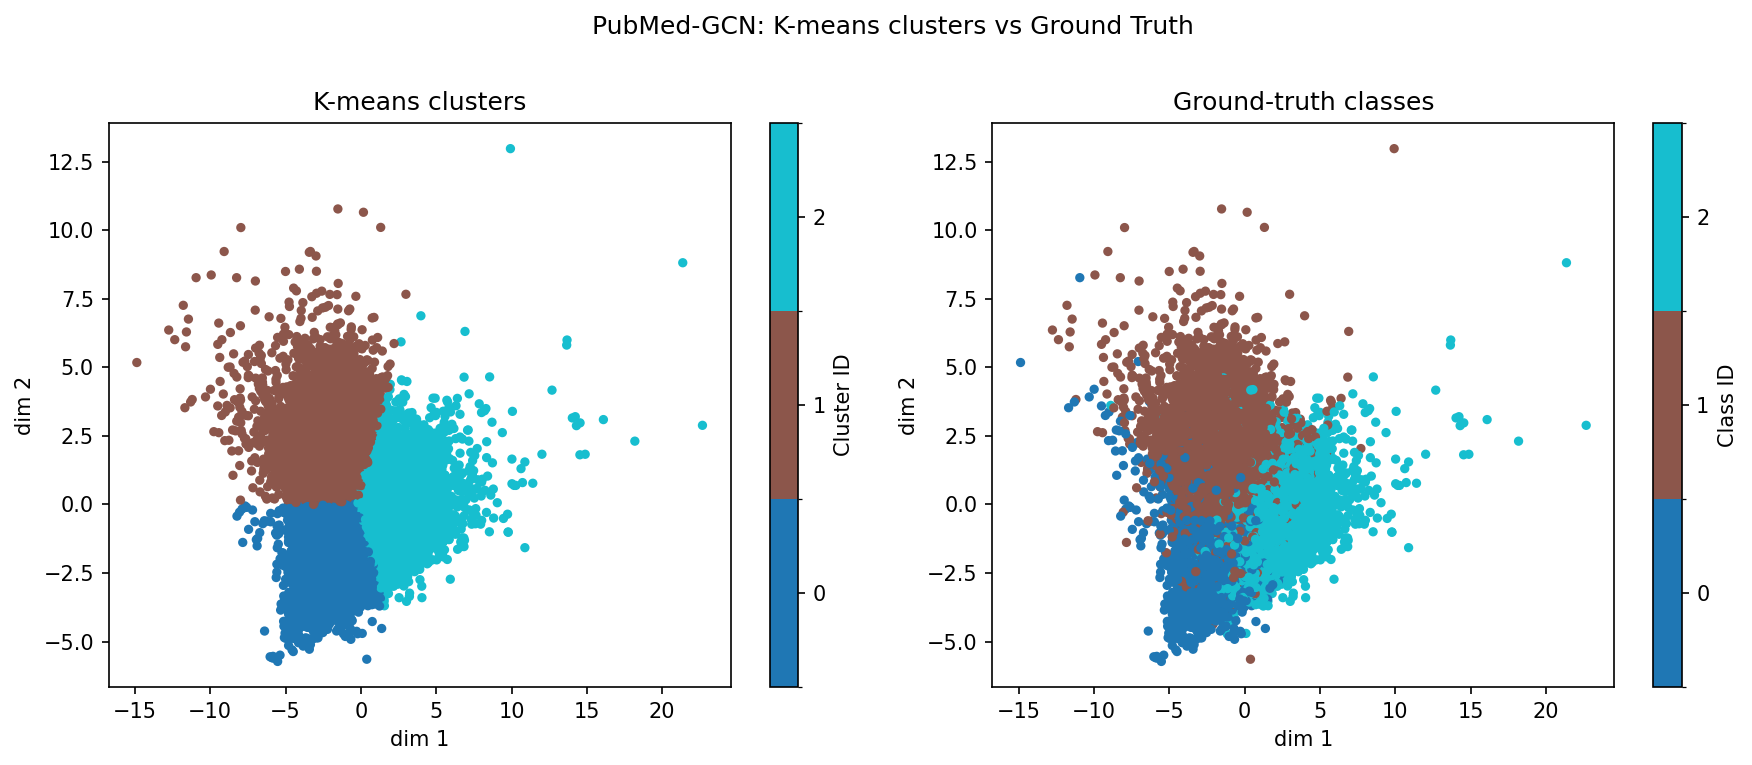

Saved plot to: /content/Results/KMeans_vs_GroundTruth.png
k (clusters) = 3 | #classes = 3


In [14]:
# --------------------------------------------------
# Reduce embeddings to 2D
# --------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# --------------------------------------------------
# Discrete colormaps (so categories are clearly separated)
# --------------------------------------------------
k_clusters = int(np.unique(pred_clusters).size)
k_labels   = int(np.unique(y_true).size)

cmap_clusters = plt.get_cmap("tab20", k_clusters) if k_clusters > 10 else plt.get_cmap("tab10", k_clusters)
cmap_labels   = plt.get_cmap("tab20", k_labels)   if k_labels > 10 else plt.get_cmap("tab10", k_labels)

norm_clusters = mcolors.BoundaryNorm(np.arange(-0.5, k_clusters + 0.5, 1), cmap_clusters.N)
norm_labels   = mcolors.BoundaryNorm(np.arange(-0.5, k_labels + 0.5, 1), cmap_labels.N)

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "KMeans_vs_GroundTruth.png"

# --------------------------------------------------
# One figure with two panels
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# LEFT: raw KMeans cluster IDs (0..k-1)
sc0 = axes[0].scatter(X2[:, 0], X2[:, 1], c=pred_clusters, s=12, cmap=cmap_clusters, norm=norm_clusters)
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

# RIGHT: ground-truth labels (real class IDs)
sc1 = axes[1].scatter(X2[:, 0], X2[:, 1], c=y_true, s=12, cmap=cmap_labels, norm=norm_labels)
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

# Colorbars (make IDs explicit)
cbar0 = fig.colorbar(sc0, ax=axes[0], ticks=range(k_clusters))
cbar0.set_label("Cluster ID")

cbar1 = fig.colorbar(sc1, ax=axes[1], ticks=range(k_labels))
cbar1.set_label("Class ID")

fig.suptitle("PubMed-GCN: K-means clusters vs Ground Truth", y=1.01)
fig.tight_layout()

fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")
print("k (clusters) =", k_clusters, "| #classes =", k_labels)


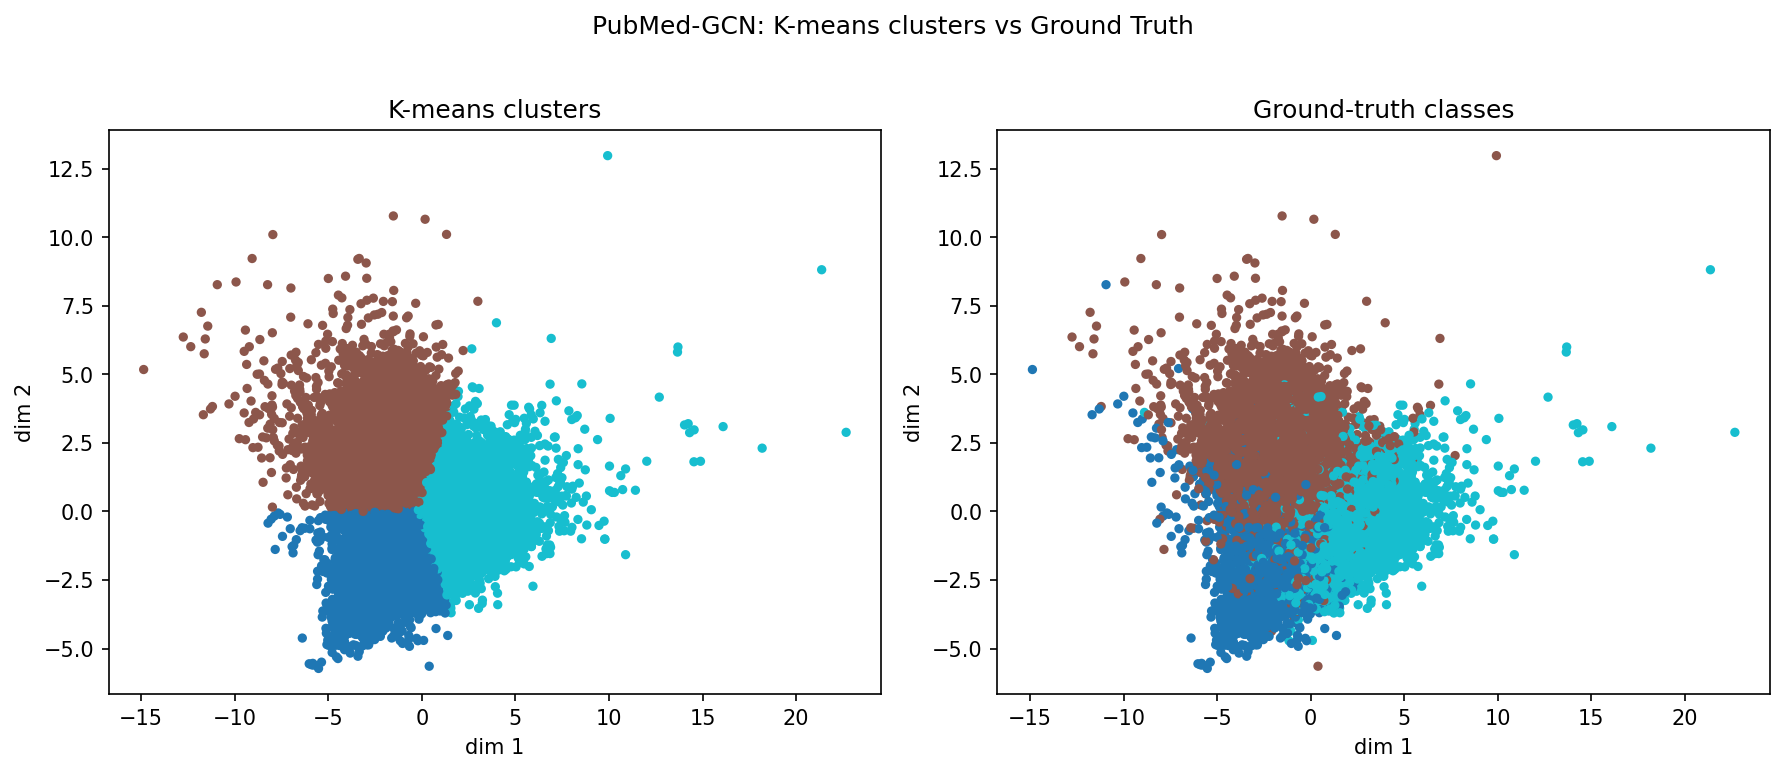

Saved plot to: /content/Results/KMeans_vs_GroundTruth_map.png


In [15]:
# -------------------------------------------------
# Results directory
# -------------------------------------------------
RESULTS_DIR = Path("/content/Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "KMeans_vs_GroundTruth_map.png"

# -------------------------------------------------
# Align cluster IDs to dominant true labels
# -------------------------------------------------
def align_clusters_to_labels(clusters, true_labels):
    clusters_aligned = np.zeros_like(clusters)
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        most_common_label = mode(true_labels[mask], keepdims=False).mode
        clusters_aligned[mask] = most_common_label
    return clusters_aligned

clusters_aligned = align_clusters_to_labels(pred_clusters, y_true)

# -------------------------------------------------
# Reduce embeddings to 2D
# -------------------------------------------------
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

# -------------------------------------------------
# Combined plot (side-by-side)
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Left: K-means clusters
axes[0].scatter(X2[:, 0], X2[:, 1],
                c=clusters_aligned, s=12, cmap="tab10")
axes[0].set_title("K-means clusters")
axes[0].set_xlabel("dim 1")
axes[0].set_ylabel("dim 2")

# Right: ground-truth labels
axes[1].scatter(X2[:, 0], X2[:, 1],
                c=y_true, s=12, cmap="tab10")
axes[1].set_title("Ground-truth classes")
axes[1].set_xlabel("dim 1")
axes[1].set_ylabel("dim 2")

fig.suptitle("PubMed-GCN: K-means clusters vs Ground Truth", y=1.02)
plt.tight_layout()

plt.savefig(out_png, bbox_inches="tight")
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")


## Build expanded Adjacency Matrix
The purpose is:
Constructs the expanded adjacency matrix W used in SpecF, encoding both: actual edges, and same-community non-edges

In [16]:
def build_expanded_adjacency(
    G: nx.Graph,
    communities: Dict[Hashable, int],
    *,
    w_edge_same: int = 5,
    w_edge_diff: int = 3,
    w_nonedge_same: int = 1,
    return_node_order: bool = False,
) -> Tuple[csr_matrix, list] | csr_matrix:
    """
    Build the expanded adjacency matrix W (Eq. (10) in the paper).

    Parameters
    ----------
    G : nx.Graph
        Undirected graph.
    communities : dict
        Mapping node -> community id (your K-means clusters).
    w_edge_same : int
        Weight if i-j are neighbors and in the same community (default 5).
    w_edge_diff : int
        Weight if i-j are neighbors in different communities (default 3).
    w_nonedge_same : int
        Weight if i-j are NOT neighbors and in the same community (default 1).
    return_node_order : bool
        If True, also returns the node order used for indexing rows/cols.

    Returns
    -------
    W : scipy.sparse.csr_matrix, shape (N, N)
        Expanded adjacency matrix.
    node_order : list (optional)
        The node order corresponding to rows/cols of W (only if return_node_order=True).
    """
    # fix node order (rows/cols)
    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}

    # neighbor sets
    nbrs = {u: set(G.neighbors(u)) for u in nodes}

    rows, cols, data = [], [], []

    # 1) Add all existing edges with weights 5 or 3
    for u, v in G.edges():
        i, j = idx[u], idx[v]
        same = (communities.get(u) == communities.get(v))
        w = w_edge_same if same else w_edge_diff
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([w, w])

    # 2) Add same-community non-edges (weight 1)
    # Group nodes by community
    comm2nodes: Dict[int, list] = {}
    for u, c in communities.items():
        comm2nodes.setdefault(c, []).append(u)

    for c, c_nodes in comm2nodes.items():
        # iterate unordered pairs inside the community
        for u, v in combinations(c_nodes, 2):
            # skip if (u,v) already an edge
            if v in nbrs[u]:
                continue
            i, j = idx[u], idx[v]
            rows.extend([i, j])
            cols.extend([j, i])
            data.extend([w_nonedge_same, w_nonedge_same])

    # Build sparse; zero diagonal by default
    W = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    return (W, nodes) if return_node_order else W


In [17]:
def calculate_community_seeds(G, communities):
    """
    Implements Equation 11: Calculates the seed signal s_k^c for each community.
    """
    # 1. Build the Community Graph (Gc)
    Gc = nx.Graph()
    unique_comms = sorted(list(set(communities.values())))
    Gc.add_nodes_from(unique_comms)

    # Count edges between communities
    for u, v in G.edges():
        c_u = communities[u]
        c_v = communities[v]
        if c_u != c_v:
            if Gc.has_edge(c_u, c_v):
                Gc[c_u][c_v]['weight'] += 1
            else:
                Gc.add_edge(c_u, c_v, weight=1)

    # 2. Calculate Seeds (Equation 11)
    community_signals = {}
    # Sort communities by the sum of their inter-community edge weights
    sorted_comms = sorted(unique_comms, key=lambda c: sum(d['weight'] for _, _, d in Gc.edges(c, data=True)))

    for i, c in enumerate(sorted_comms):
        # sum of weights of adjacent nodes in Gc
        w_sum = sum(d['weight'] for _, _, d in Gc.edges(c, data=True))
        # Equation 11: s_i^c = sum(w_ij^c) * (i + 1)
        community_signals[c] = float(w_sum * (i + 1))

    return community_signals

## Generating Normal Signals

Its job:

Seed a signal inside each community:

- For each community c, find nodes in that community.

- Choose a seed node with maximum degree (or random among them).

- Set its signal s_i^c to the corresponding community-level value community_signal[c].

- Everything else initially 0.

Propagate that signal outward:

- Uses a kind of queue-based propagation:

  - Maintains a set of marked/unmarked nodes.

  - Repeatedly selects a node, pushes its signal to neighbors, and averages.

- The conceptual effect: values diffuse across the graph so that nodes connected within the same community tend to have similar values.

Final smoothing with weights:

- If W_expanded and node_order are provided (fast path):

  - Build a vector sx_vec of signals in the order of node_order.

  - Compute row_sums = W_expanded.sum(axis=1) (degree in expanded graph).

  - Compute numer = W_expanded.dot(sx_vec) (weighted sum of neighbors’ signals).

  - Set s_vec = numer / row_sums where degree > 0.

  - Convert back to a dict {node: s_i}.

- This is a weighted average using expanded adjacency, so the signal is smooth with respect to both edges and community structure.

In [18]:
# BUILD NETWORKX GRAPH G FROM PyG edge_index
edge_index = data.edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(zip(edge_index[0], edge_index[1]))
G.add_nodes_from(range(data.num_nodes))   # ensure isolated nodes included

def normal_signal_generator(
    G: nx.Graph,
    communities: Dict[Hashable, int],               # node -> community id
    community_signal: Dict[int, float],             # community id -> seed s_k^c
    *,
    # legacy options
    use_expanded_weights: bool = False,             # if no W_expanded is given, use 5/3 scheme
    weight_attr: str = "weight",                    # edge attr for legacy averaging
    rng: Optional[random.Random] = None,
    # NEW fast path
    W_expanded: "csr_matrix" = None,                # SciPy CSR matrix (optional)
    node_order: Optional[list] = None               # nodes ordered as W_expanded rows/cols
) -> Dict[Hashable, float]:
    """
    Algorithm 4: Normal Signal Generator (paper).
    - Seeds each community at its highest-degree node with s_k^c.
    - Propagates signals along edges with community-aware transfer t.
    - Final signal is a weighted average of propagated signals.

    Fast path:
      If W_expanded (CSR) and node_order are provided, the final averaging uses:
         s = D^{-1} W_expanded @ s_x
      where D[i] = sum_j W_expanded[i, j].
    Otherwise, falls back to the legacy (loop-based) averaging.

    Returns
    -------
    s : dict {node: s_i}  Final node signals.
    """
    if rng is None:
        rng = random.Random()

    # 1. Initialization
    # S_x will hold the intermediate propagated values
    S_x: Dict[Hashable, float] = {n: 0.0 for n in G.nodes()}
    marked = {n: True for n in G.nodes()}
    degrees = dict(G.degree())

    # Queue for BFS-like propagation
    F = deque()

    # 2. Seed Selection (Heads of Communities)
    # Identify unique communities present in the graph
    present_communities = set(communities.values())

    # Pre-group nodes by community for efficiency
    nodes_by_comm = {c: [] for c in present_communities}
    for n, c in communities.items():
        if n in G:  # Ensure node is in graph
            nodes_by_comm[c].append(n)

    # Assign seed values to the highest degree node in each community
    for c in present_communities:
        nodes = nodes_by_comm[c]
        if not nodes:
            continue

        # Sort by degree (descending) then ID to break ties deterministically
        # Note: we use str(n) for ID sorting to handle mixed types if necessary
        head = max(nodes, key=lambda n: (degrees[n], str(n)))

        # Assign the seed signal for this community
        if c in community_signal:
            S_x[head] = community_signal[c]
            marked[head] = False
            F.append(head)

    # 3. Propagation Process (The core of Algorithm 4)
    while F:
        v_i = F.popleft()
        val_i = S_x[v_i]

        # Get neighbors (sorted for determinism if needed, but omitted for speed)
        neighbors = list(G.neighbors(v_i))

        for v_j in neighbors:
            # Calculate transfer rate 't'
            # If same community: t depends on degrees
            if communities[v_i] == communities[v_j]:
                d_i = degrees[v_i]
                d_j = degrees[v_j]
                denom = d_i + d_j
                mt = (d_i / denom) if denom > 0 else 0
                t = max(0.25, mt)
            else:
                # Different community: fixed low transfer rate
                t = 0.1

            # Update neighbor value: s_j <- s_j + (s_i * t)
            S_x[v_j] += val_i * t

            # Decay source value: s_i <- s_i * 0.95
            S_x[v_i] *= 0.95
            # Update local var to reflect decay for next neighbor (optional interpretation,
            # but usually decay happens once per propagation step.
            # Sticking to the paper's "After the propagation process... reduced by 5%" implies
            # it might happen after interacting with all neighbors, but iterative implementations
            # often decay per interaction. Here we decay the source *in the dict*.)

            # Add neighbor to queue if it hasn't been a source yet
            if marked[v_j]:
                marked[v_j] = False
                F.append(v_j)

        # Update the decayed value in the main dict for v_i
        S_x[v_i] = val_i * 0.95

    # 4. Final Normalization
    # We apply the weighted average smoothing.

    # PATH A: Fast path with Precomputed W_expanded
    if W_expanded is not None:
        if node_order is None:
            raise ValueError("node_order must be provided if W_expanded is used.")

        # Create a vector aligned with node_order
        n_nodes = len(node_order)
        s_vector = np.zeros(n_nodes)

        # Map S_x dict to vector
        # Create a fast lookup for node indices
        node_to_idx = {n: i for i, n in enumerate(node_order)}

        for n, val in S_x.items():
            if n in node_to_idx:
                s_vector[node_to_idx[n]] = val

        # Perform matrix multiplication: S_smooth = D^-1 * W * S
        # Compute sum of weights (degrees) for normalization
        # W_expanded is CSR, sum(axis=1) returns a matrix (n,1), flatten to array
        weighted_sums = W_expanded.dot(s_vector)
        degree_sums = np.array(W_expanded.sum(axis=1)).flatten()

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            s_smooth_vec = weighted_sums / degree_sums
            s_smooth_vec = np.nan_to_num(s_smooth_vec)

        # Map back to dict
        return {n: float(s_smooth_vec[i]) for i, n in enumerate(node_order)}

    # PATH B: Legacy Manual Calculation
    else:
        S_final = {}
        for i in G.nodes():
            neighbors = list(G.neighbors(i))

            # If isolated, keep original value
            if not neighbors:
                S_final[i] = S_x[i]
                continue

            numerator = 0.0
            denominator = 0.0

            # Define weights based on strategy
            if use_expanded_weights:
                # "Expanded" strategy: 5 for same comm, 3 for diff comm
                # We include self-loop with weight 5 (high affinity to self/comm)

                # Self
                w_self = 5.0
                numerator += w_self * S_x[i]
                denominator += w_self

                c_i = communities[i]

                for j in neighbors:
                    if c_i == communities[j]:
                        w = 5.0
                    else:
                        w = 3.0
                    numerator += w * S_x[j]
                    denominator += w
            else:
                # Standard strategy: use edge weight attribute or 1.0
                # Self (standard usually doesn't emphasize self as heavily, using 1.0 or 0)
                # Here we strictly average neighbors + self? Or just neighbors?
                # Standard smoothing usually involves self. Let's assume weight 1 for self.
                numerator += S_x[i]
                denominator += 1.0

                for j in neighbors:
                    w = G[i][j].get(weight_attr, 1.0)
                    numerator += w * S_x[j]
                    denominator += w

            S_final[i] = numerator / denominator if denominator > 0 else 0.0

        return S_final

# 1. Map communities
clusters_dict = {i: int(c) for i, c in enumerate(pred_clusters)}

# 2. CALCULATE SEEDS (The missing step)
# This uses the inter-community edge counts to set the base intensity
Sc = calculate_community_seeds(G, clusters_dict)

# 3. Build W_expanded
W_expanded, node_order = build_expanded_adjacency(G, clusters_dict, return_node_order=True)

# 4. Propagation (Algorithm 4)
# Now Sc contains the paper-derived s_k^c values
S_normal = normal_signal_generator(
    G,
    communities=clusters_dict,
    community_signal=Sc,
    W_expanded=W_expanded,
    node_order=node_order
)

B = S_normal

pure visualization of the input signal 𝐵 on a low-dimensional embedding of the graph nodes.

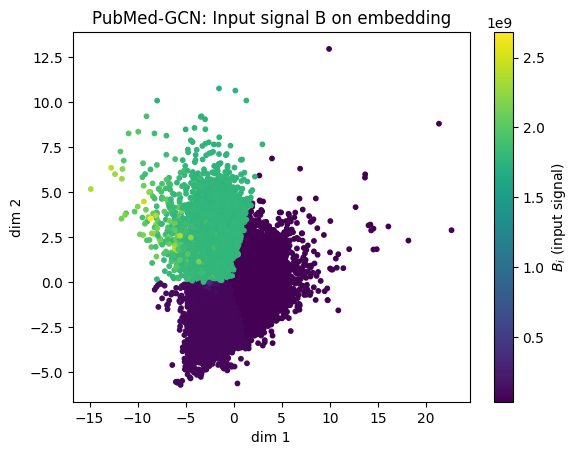

In [19]:
# convert dict -> array, assuming node ids are 0..N-1
vals_B = np.array([B[i] for i in range(len(B))])

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=vals_B, s=10, cmap="viridis")
plt.colorbar(label=r"$B_i$ (input signal)")
plt.title("PubMed-GCN: Input signal B on embedding")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()


#**SpecF**

In [20]:
def specf_anomaly_detection(
    W_expanded: csr_matrix,
    B: Dict[Hashable, float],          # anomalous signal: node -> b_i
    communities: Dict[Hashable, int],  # node -> community id (from K-means)
    node_order: list,                  # order used when building W_expanded
    k: int | None = None               # how many low-frequency modes to keep
):
    """
    SpecF implementation (sparse / scalable version):

    - Build sparse Laplacian L = D - W_expanded.
    - Compute only the k smallest eigenpairs of L (low frequencies).
    - Graph Fourier transform of B using those eigenvectors.
    - Reconstruct a smoothed signal b' from low-frequency modes only.
    - Y = |B - B'| = anomaly score per node.
    - Per-community thresholding to get the anomaly set.
    """

    # 1. Build signal vector in the same order as W_expanded
    N = W_expanded.shape[0]
    assert len(node_order) == N, "node_order must match W_expanded shape"
    b_vec = np.array([B[n] for n in node_order], dtype=float)

    # 2. Build sparse Laplacian L = D - W_expanded
    deg = np.array(W_expanded.sum(axis=1)).ravel()
    D = diags(deg)                       # sparse degree matrix
    L = D - W_expanded                  # sparse Laplacian

    # 3. Decide how many eigenvectors to compute
    if k is None:
        k = len(set(communities.values()))   # use #communities if not given

    # Safety: k must be < N and at least 1
    k = max(1, min(k, N - 2))

    # 4. Compute the k smallest eigenpairs of L (low frequencies)
    # eigsh works with sparse symmetric matrices
    eigvals, U_low = eigsh(L, k=k, which="SM")   # shape U_low: (N, k)

    # (Optional) sort them by eigenvalue ascending
    order = np.argsort(eigvals)
    eigvals = eigvals[order]
    U_low = U_low[:, order]

    # 5. Graph Fourier transform of B on the low-frequency basis
    #    b_hat_low[l] = u_l^T b
    b_hat_low = U_low.T @ b_vec           # shape (k,)

    # 6. Ideal low-pass filter:
    #    since we only have the k smallest eigenvectors,
    #    using all of them is equivalent to keeping frequencies λ_0..λ_{k-1}
    #    and discarding all higher ones.
    #    -> no extra masking needed: they are already low-pass.

    # 7. Inverse transform (reconstruction from low-frequency modes)
    #    b'(i) = sum_{l=0}^{k-1} b_hat_low[l] * u_l(i)
    b_prime = U_low @ b_hat_low           # shape (N,)

    # 8. Anomaly scores Y = |B - B'|
    y_vec = np.abs(b_vec - b_prime)
    Y_scores = {n: y_vec[i] for i, n in enumerate(node_order)}  # node -> y_i

    # 9. Per-community thresholding
    anomalies = []
    comm_to_nodes: Dict[int, list] = {}
    for n in node_order:
        c = int(communities[n])
        comm_to_nodes.setdefault(c, []).append(n)

    for c, nodes_c in comm_to_nodes.items():
        vals = np.array([Y_scores[n] for n in nodes_c], dtype=float)
        if len(vals) == 0:
            continue

        mu = vals.mean()
        sigma = vals.std()

        # Threshold: mean + 2 * std within each community
        #   y_i > μ_c + 2 σ_c  ⇒ anomalous
        threshold = mu + 2.0 * sigma

        for n, y in zip(nodes_c, vals):
            if y > threshold:
                anomalies.append(n)

    return Y_scores, anomalies


In [21]:
# Calling SpecF Algorithm
k_communities = len(set(clusters_dict.values()))
print("Number of communities (k):", k_communities)

Y_scores, specf_anomalies = specf_anomaly_detection(
    W_expanded=W_expanded,
    B=B,
    communities=clusters_dict,
    node_order=node_order,
    k=k_communities
)

print(f"SpecF flagged {len(specf_anomalies)} anomalous nodes.")
print("First 10:", specf_anomalies[:10])


Number of communities (k): 3
SpecF flagged 483 anomalous nodes.
First 10: [np.int64(15413), np.int64(19280), np.int64(10056), np.int64(1303), np.int64(19645), np.int64(4490), np.int64(1921), np.int64(13220), np.int64(6095), np.int64(7615)]


# Results

# Node Embedding Colored by SpecF Score 𝑌𝑖 with anomalous in red circle

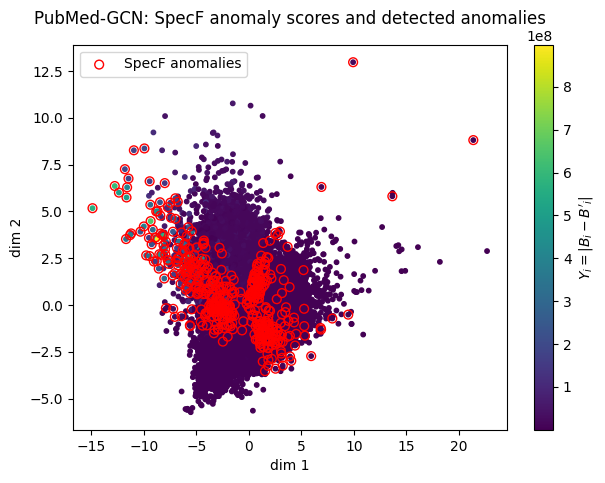

Saved plot to: /content/Results/SpecF_scores_with_anomalies.png


In [22]:
# ---- SpecF score vector in node-id order 0..N-1 ----
N = len(node_order)  # should equal data.num_nodes
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# anomaly mask for highlighting circles
mask = np.zeros(N, dtype=bool)
mask[specf_anomalies] = True

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_with_anomalies.png"

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(7, 5))

plt.scatter(X2[:, 0], X2[:, 1], c=vals_Y, s=10, cmap="viridis")
plt.colorbar(label=r"$Y_i = |B_i - B'_i|$")

plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40, edgecolors="red", facecolors="none",
    linewidths=1.0, label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("PubMed-GCN: SpecF anomaly scores and detected anomalies", pad=15)
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")


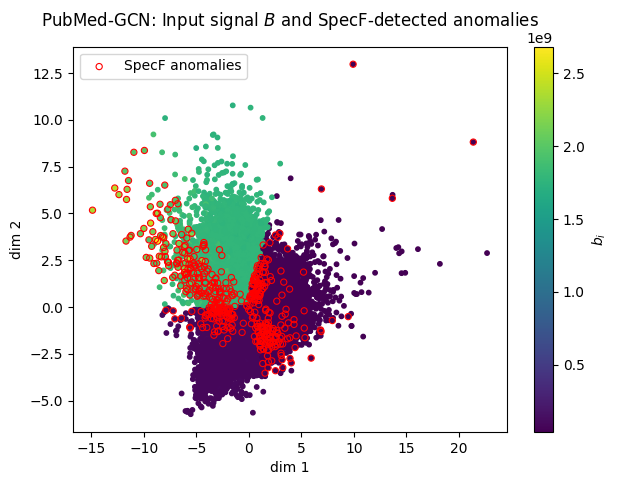

Saved plot to: /content/Results/InputSignal_B_with_anomalies.png


In [23]:
# convert dict -> array, assuming node ids are 0..N-1
vals_B = np.array([B[i] for i in range(len(B))])

# create anomaly mask for highlighting red circles
mask = np.zeros(len(B), dtype=bool)
mask[specf_anomalies] = True

# --------------------------------------------------
# Results folder
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "InputSignal_B_with_anomalies.png"

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(7, 5))

plt.scatter(X2[:, 0], X2[:, 1], c=vals_B, s=10, cmap="viridis")
plt.colorbar(label=r"$b_i$")

plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=20, edgecolors="red", facecolors="none",
    linewidths=0.8, label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("PubMed-GCN: Input signal $B$ and SpecF-detected anomalies", pad=15)
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")

# Community Structure in PCA Space with SpecF Anomalies

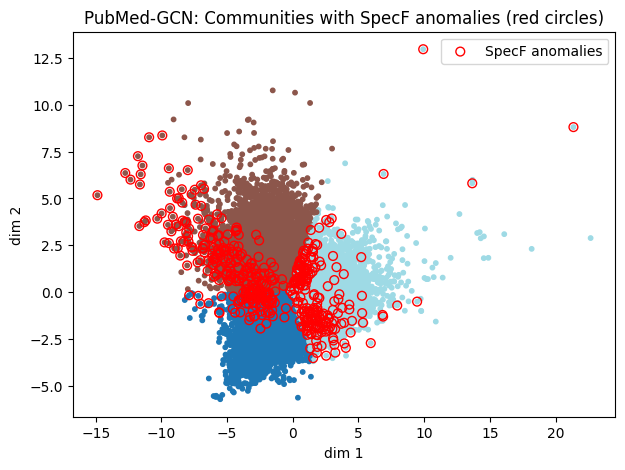

Saved plot to: /content/Results/Communities_with_SpecF_anomalies.png


In [24]:
comm_vec = np.array([clusters_dict[i] for i in range(len(node_order))], dtype=int)

mask = np.zeros(len(node_order), dtype=bool)
mask[specf_anomalies] = True

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Communities_with_SpecF_anomalies.png"

plt.figure(figsize=(7, 5))

plt.scatter(X2[:, 0], X2[:, 1], c=comm_vec, s=10, cmap="tab20")

plt.scatter(
    X2[mask, 0], X2[mask, 1],
    s=40, edgecolors="red", facecolors="none",
    linewidths=1.0, label="SpecF anomalies"
)

plt.legend(loc="best")
plt.title("PubMed-GCN: Communities with SpecF anomalies (red circles)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

# Save under Results
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")

**SpecF Anomaly Detection Results in PCA Space**

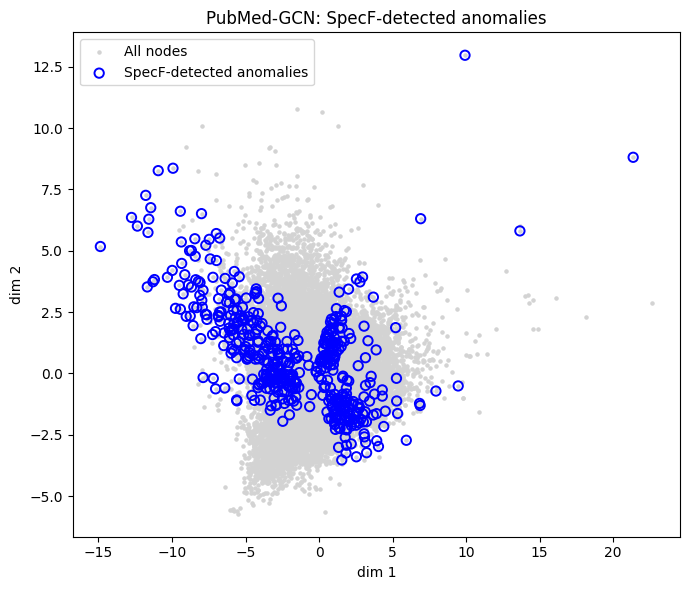

Saved plot to: /content/Results/SpecF_detected_anomalies.png


In [25]:
N = len(node_order)
specf_set = set(specf_anomalies)


# SpecF flagged nodes only (no TP/FN/FP without ground truth)
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True   # SpecF-detected anomalies


RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "SpecF_detected_anomalies.png"


plt.figure(figsize=(7, 6))

# background: all nodes
plt.scatter(
    X2[:, 0], X2[:, 1],
    s=5, color="lightgray", label="All nodes"
)

# SpecF anomalies
plt.scatter(
    X2[mask_anom, 0], X2[mask_anom, 1],
    s=45, edgecolors="blue", facecolors="none",
    linewidths=1.4, label="SpecF-detected anomalies"
)

plt.legend()
plt.title("PubMed-GCN: SpecF-detected anomalies")
plt.xlabel("dim 1")
plt.ylabel("dim 2")

plt.tight_layout()

# Save under Results
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")

**Community-wise Distribution of Detected Anomalies**

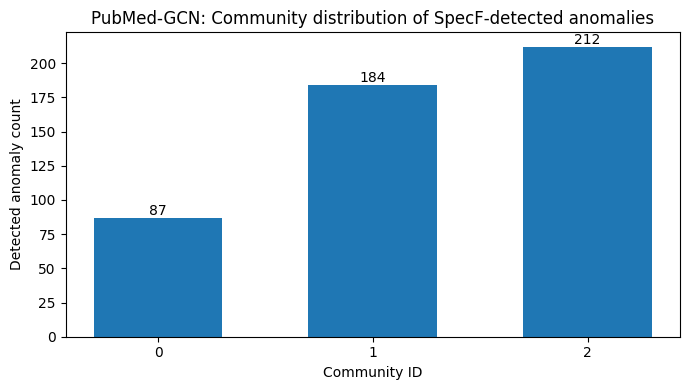

In [27]:
# Communities of SpecF-detected anomalies
detected_comms = [clusters_dict[n] for n in specf_set]
detected_cnt = Counter(detected_comms)

all_comms = sorted(detected_cnt)
x = np.arange(len(all_comms))
vals = [detected_cnt[c] for c in all_comms]

plt.figure(figsize=(7,4))
bars = plt.bar(x, vals, width=0.6)

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(x, all_comms)
plt.xlabel("Community ID")
plt.ylabel("Detected anomaly count")
plt.title("PubMed-GCN: Community distribution of SpecF-detected anomalies")
plt.tight_layout()
plt.show()

In [28]:
# --------------------------------------------------
# 1. Dataset info
# --------------------------------------------------
labels = data.y.cpu().numpy()
N = data.num_nodes

# --------------------------------------------------
# 2. Full table (ADD title column)
# --------------------------------------------------
df_results = pd.DataFrame({
    "node_id": np.arange(N),
    "title": data.titles,          # <-- ADDED (already aligned with nodes)
    "label_id": labels,
    "community_id": [clusters_dict[i] for i in range(N)],
    "SpecF_score": [Y_scores[i] for i in range(N)]
})

# --------------------------------------------------
# 3. Keep ONLY anomalies and drop index
#    Robust for PubMed and reordered nodes
# --------------------------------------------------
specf_anomalies = np.asarray(specf_anomalies, dtype=int)

df_anomalies = (
    df_results[df_results["node_id"].isin(specf_anomalies)]
    .sort_values("SpecF_score", ascending=False)
    .reset_index(drop=True)
)

# --------------------------------------------------
# 4. Display (full titles)
# --------------------------------------------------
pd.set_option("display.max_colwidth", None)
display(df_anomalies)

# --------------------------------------------------
# 5. Export to Excel (with wrapped titles)
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

output_file = RESULTS_DIR / "PubMed_SpecF_anomalies_GCN.xlsx"

df_anomalies.to_excel(output_file, index=False, engine="openpyxl")

# enable wrap-text for title column
wb = load_workbook(output_file)
ws = wb.active

wrap = Alignment(wrap_text=True, vertical="top")

# find title column index
headers = [cell.value for cell in ws[1]]
col_title = headers.index("title") + 1

for row in range(2, ws.max_row + 1):
    ws.cell(row=row, column=col_title).alignment = wrap

wb.save(output_file)

print(f"Excel file saved successfully at: {output_file.resolve()}")


,node_id,title,label_id,community_id,SpecF_score
0,17485,Checkpoints in the progression of autoimmune disease: lessons from diabetes models.,1,1,8.981874e+08
1,11260,In autoimmune diabetes the transition from benign to pernicious insulitis requires an islet cell response to tumor necrosis factor alpha.,1,1,7.996260e+08
2,2104,Initiation of autoimmune diabetes by developmentally regulated presentation of islet cell antigens in the pancreatic lymph nodes.,1,1,6.492483e+08
3,12639,Following a diabetogenic T cell from genesis through pathogenesis.,1,1,6.054674e+08
4,17092,Reduced incidence and delayed onset of diabetes in perforin-deficient nonobese diabetic mice.,1,1,5.845684e+08
...,...,...,...,...,...
478,17016,Improved carbohydrate metabolism after bariatric surgery raises antioxidized LDL antibody levels in morbidly obese patients.,2,2,3.107674e+06
479,9226,Mapping genes in diabetes. Genetic epidemiological perspective.,1,2,3.101961e+06
480,729,Metabolic rhythms in adolescents with diabetes during treatment with porcine or human insulin.,1,2,3.081686e+06
481,11697,Prevention of glucose toxicity in HIT-T15 cells and Zucker diabetic fatty rats by antioxidants.,2,2,3.077634e+06


Excel file saved successfully at: /content/Results/PubMed_SpecF_anomalies_GCN.xlsx


# Count NORMAL vs ANOMALOUS per community

In [29]:
stats = defaultdict(lambda: {
    "total": 0,
    "normal": 0,
    "anomalous": 0
})

for i in range(data.num_nodes):
    comm = int(clusters_dict[i])
    stats[comm]["total"] += 1
    if i in specf_set:
        stats[comm]["anomalous"] += 1
    else:
        stats[comm]["normal"] += 1

print("\nCommunity-wise normal vs anomalous nodes (SpecF):\n")
print(f"{'Community':>10s} | {'Total':>7s} | {'Normal':>7s} | {'Anom':>6s} | {'Anom %':>8s}")
print("-" * 65)

for comm in sorted(stats.keys()):
    s = stats[comm]
    total, anom, normal = s["total"], s["anomalous"], s["normal"]
    pct = 100.0 * anom / total if total > 0 else 0.0
    print(f"{comm:10d} | {total:7d} | {normal:7d} | {anom:6d} | {pct:7.2f}%")

# sanity checks
print("\n#communities =", len(set(clusters_dict.values())))
print("Total anomalies =", sum(stats[c]["anomalous"] for c in stats), "== len(specf_set):", len(specf_set))


Community-wise normal vs anomalous nodes (SpecF):

 Community |   Total |  Normal |   Anom |   Anom %
-----------------------------------------------------------------
         0 |    5490 |    5403 |     87 |    1.58%
         1 |    5476 |    5292 |    184 |    3.36%
         2 |    8751 |    8539 |    212 |    2.42%

#communities = 3
Total anomalies = 483 == len(specf_set): 483


Vizualize

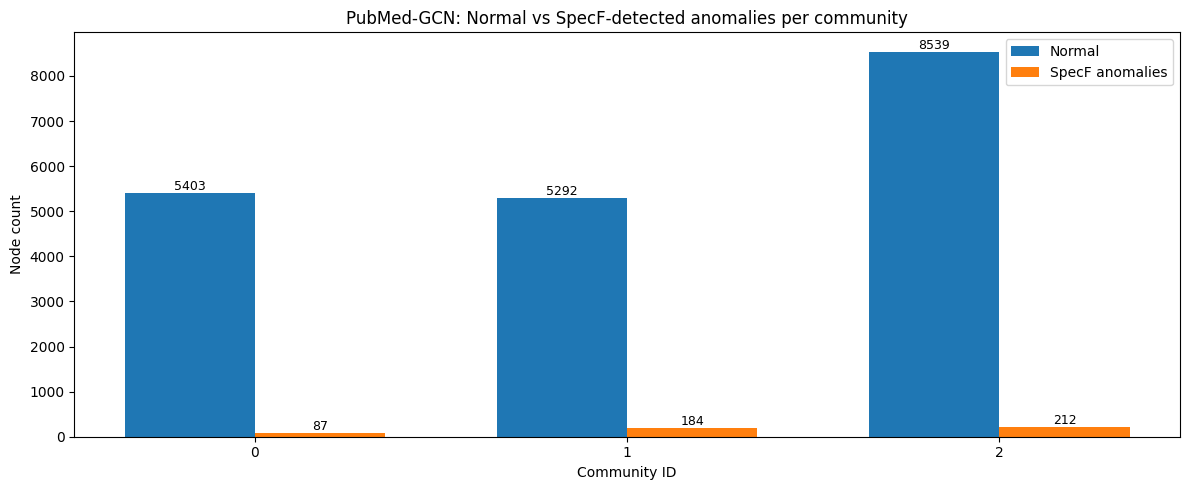

Saved plot to: /content/Results/Normal_vs_SpecF_anomalies_per_community.png


In [30]:
# communities (sorted, numeric)
comms = sorted(stats.keys())

normal_vals = [stats[c]["normal"] for c in comms]
anom_vals   = [stats[c]["anomalous"] for c in comms]

x = np.arange(len(comms))
width = 0.35

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "Normal_vs_SpecF_anomalies_per_community.png"


plt.figure(figsize=(12, 5))

bars_normal = plt.bar(x - width/2, normal_vals, width, label="Normal")
bars_anom   = plt.bar(x + width/2, anom_vals,   width, label="SpecF anomalies")

# -----------------------------
# add numbers on bars
# -----------------------------
for bar in bars_normal:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        str(int(h)),
        ha="center",
        va="bottom",
        fontsize=9
    )

for bar in bars_anom:
    h = bar.get_height()
    if h > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h,
            str(int(h)),
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.xticks(x, comms)
plt.xlabel("Community ID")
plt.ylabel("Node count")
plt.title("PubMed-GCN: Normal vs SpecF-detected anomalies per community")
plt.legend()
plt.tight_layout()

# Save under Results
plt.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close()

print(f"Saved plot to: {out_png.resolve()}")


# Per-community distribution of SpecF spectral deviation scores

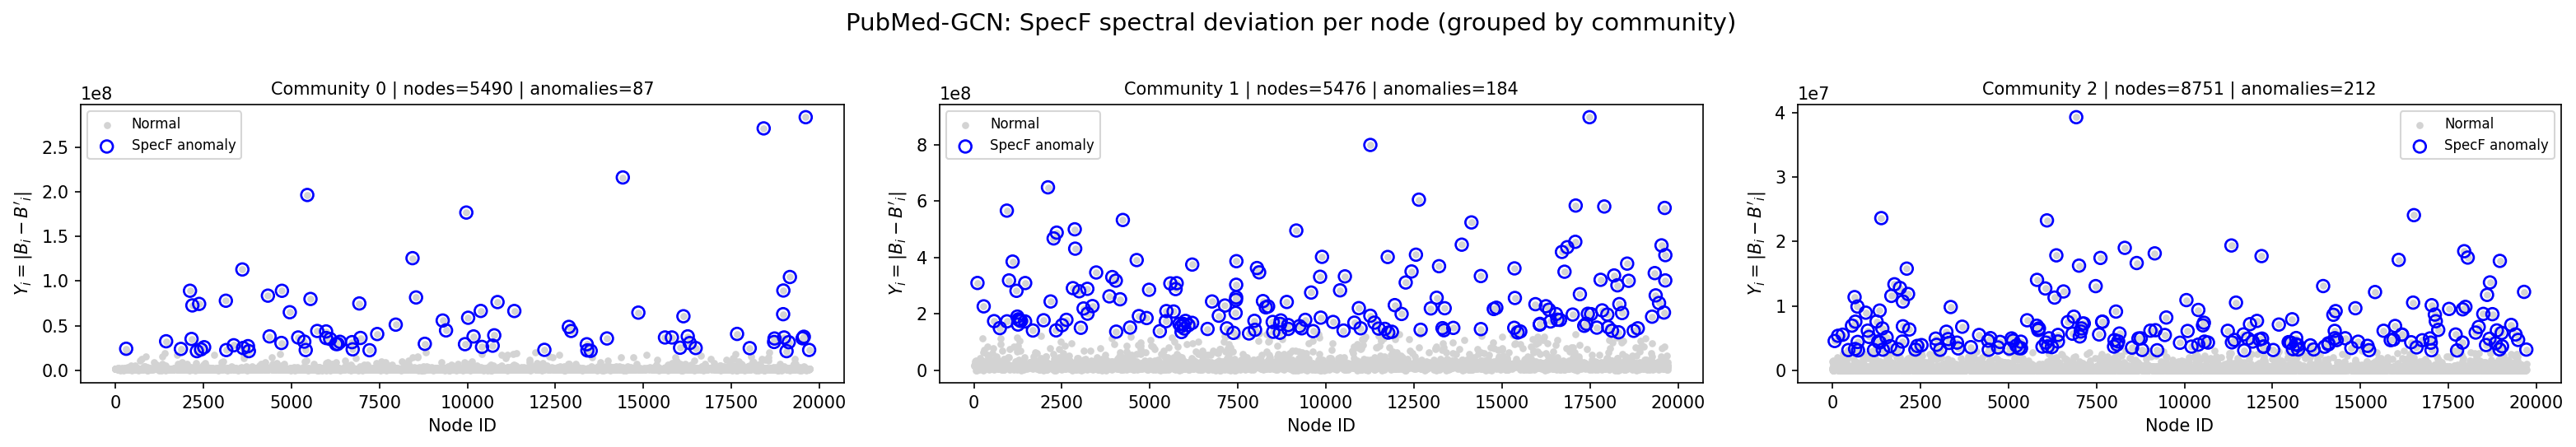

Saved plot to: /content/Results/SpecF_scores_per_community.png


In [31]:
# -------------------------------------------------
# 1. Prepare arrays (node_id = 0..N-1)
# -------------------------------------------------
N = data.num_nodes   # <-- safer for PubMed

vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
specf_set = set(map(int, specf_anomalies))

# all communities
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Plot settings
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3.5), dpi=150)
axes = np.array(axes).reshape(-1)

RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_per_community.png"


for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    idx = np.where(comm_ids == c)[0]                  # node ids in this community
    idx_anom = idx[np.isin(idx, list(specf_set))]     # anomalies inside this community

    ax.scatter(idx, vals_Y[idx], s=10, color="lightgray", label="Normal")

    if len(idx_anom) > 0:
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=50,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.3,
            label="SpecF anomaly"
        )

    ax.set_title(f"Community {c} | nodes={len(idx)} | anomalies={len(idx_anom)}", fontsize=10)
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")
    ax.legend(fontsize=8)

# turn off unused axes
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle("PubMed-GCN: SpecF spectral deviation per node (grouped by community)", fontsize=14, y=1.02)
fig.tight_layout()

# -------------------------------------------------
# 4. Save under Results
# -------------------------------------------------
fig.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

print(f"Saved plot to: {out_png.resolve()}")


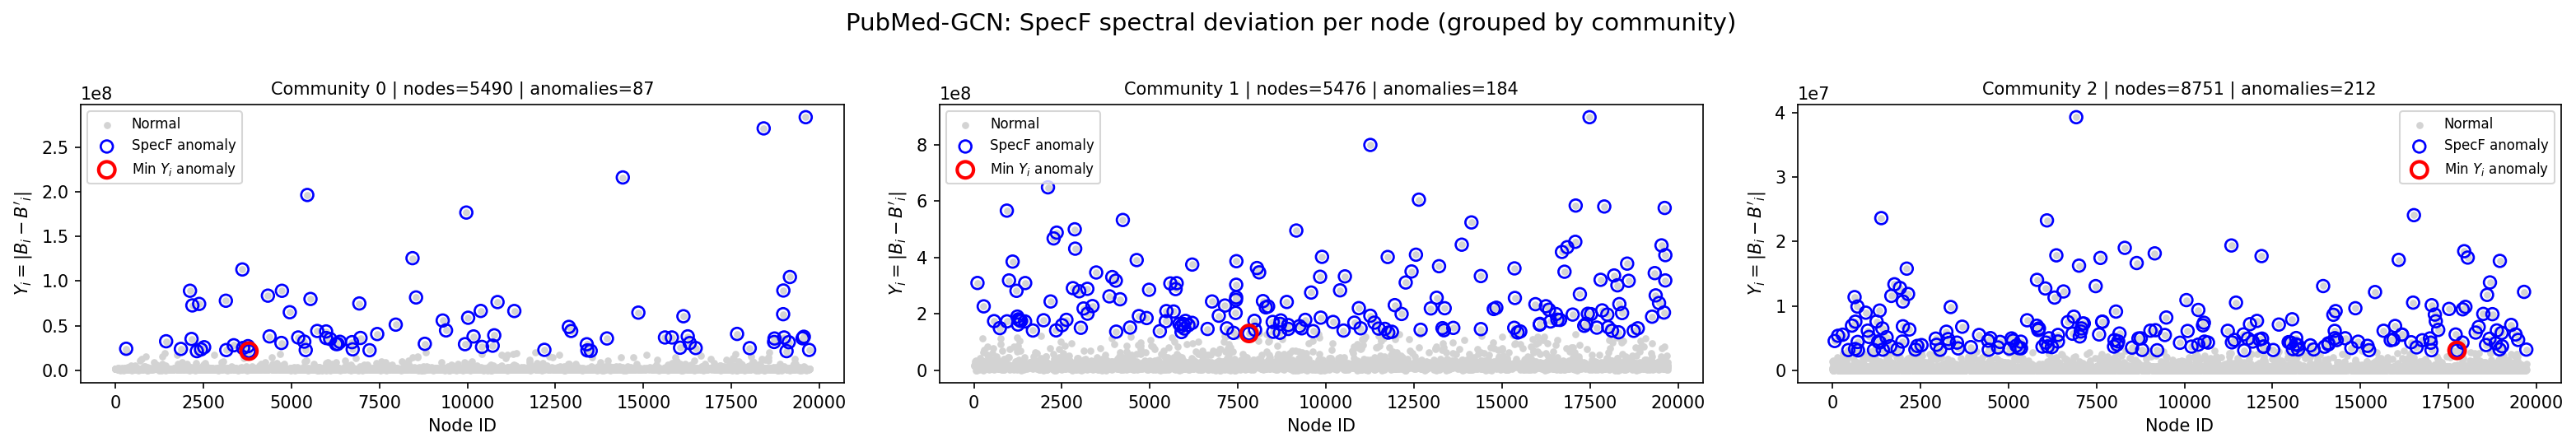

Saved plot to: /content/Results/SpecF_scores_per_community_minYi_highlighted.png


In [32]:
# -------------------------------------------------
# 1. Prepare arrays (node_id = 0..N-1)
# -------------------------------------------------
N = data.num_nodes   # safer for PubMed

vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
specf_set = set(map(int, specf_anomalies))

# all communities
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 2. Plot settings
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3.5), dpi=150)
axes = np.array(axes).reshape(-1)


RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_scores_per_community_minYi_highlighted.png"

# -------------------------------------------------
# 3. Plot per community
# -------------------------------------------------
for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    # nodes in this community
    idx = np.where(comm_ids == c)[0]

    # anomalies in this community
    idx_anom = idx[np.isin(idx, list(specf_set))]

    # plot all nodes
    ax.scatter(idx, vals_Y[idx], s=10, color="lightgray", label="Normal")

    # plot anomalies
    if len(idx_anom) > 0:
        ax.scatter(
            idx_anom,
            vals_Y[idx_anom],
            s=50,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.3,
            label="SpecF anomaly"
        )

        # -------------------------------------------------
        # highlight MIN-Y anomaly in this community (RED)
        # -------------------------------------------------
        min_idx = idx_anom[np.argmin(vals_Y[idx_anom])]

        ax.scatter(
            min_idx,
            vals_Y[min_idx],
            s=90,
            facecolors="none",
            edgecolors="red",
            linewidths=2.0,
            label="Min $Y_i$ anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={len(idx)} | anomalies={len(idx_anom)}",
        fontsize=10
    )
    ax.set_xlabel("Node ID")
    ax.set_ylabel(r"$Y_i = |B_i - B'_i|$")
    ax.legend(fontsize=8)

# turn off unused axes
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "PubMed-GCN: SpecF spectral deviation per node (grouped by community)",
    fontsize=14, y=1.02
)
fig.tight_layout()

# -------------------------------------------------
# 4. Save under Results
# -------------------------------------------------
fig.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

print(f"Saved plot to: {out_png.resolve()}")

# visualization of SpecF-detected anomalies per community

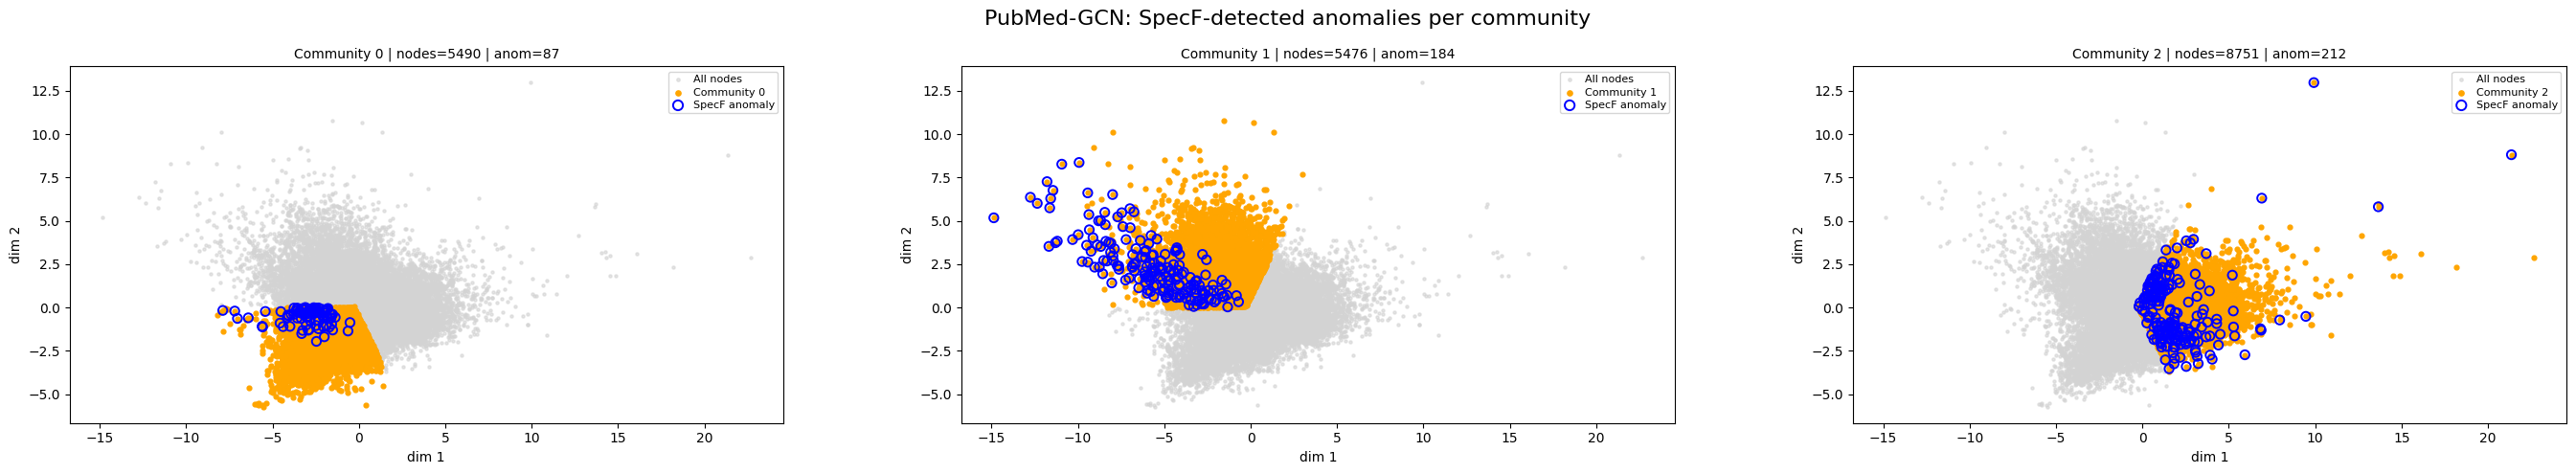

Saved plot to: /content/Results/SpecF_detected_anomalies_per_community.png


In [33]:
# -------------------------------------------------
# 1. Dataset size (PubMed-safe)
# -------------------------------------------------
N = data.num_nodes

# SpecF anomaly set (node indices)
specf_set = set(map(int, specf_anomalies))

# anomaly mask
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# -------------------------------------------------
# 2. Community IDs (aligned with data / X2)
# -------------------------------------------------
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# 3. Grid layout (single wide figure)
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 9, rows * 5)   # wider for PubMed
)
axes = np.array(axes).reshape(-1)

# -------------------------------------------------
# Results folder
# -------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_detected_anomalies_per_community.png"

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    mask_comm = (comm_ids == c)
    mask_comm_anom = mask_comm & mask_anom

    # background: all nodes
    ax.scatter(
        X2[:, 0], X2[:, 1],
        s=5, color="lightgray", alpha=0.6,
        label="All nodes"
    )

    # highlight community nodes
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=12, color="orange",
        label=f"Community {c}"
    )

    # anomalies in this community
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0],
            X2[mask_comm_anom, 1],
            s=45,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.4,
            label="SpecF anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={mask_comm.sum()} | anom={mask_comm_anom.sum()}",
        fontsize=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # -------------------------------------------------
    # Legend (map) per subplot
    # -------------------------------------------------
    ax.legend(
        loc="upper right",
        fontsize=8,
        frameon=True,
        markerscale=1.1,
        handlelength=1.2,
        borderpad=0.3,
        labelspacing=0.3
    )

# -------------------------------------------------
# 5. Remove empty subplots
# -------------------------------------------------
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "PubMed-GCN: SpecF-detected anomalies per community",
    fontsize=16
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# -------------------------------------------------
# 6. Save under Results
# -------------------------------------------------
fig.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

print(f"Saved plot to: {out_png.resolve()}")

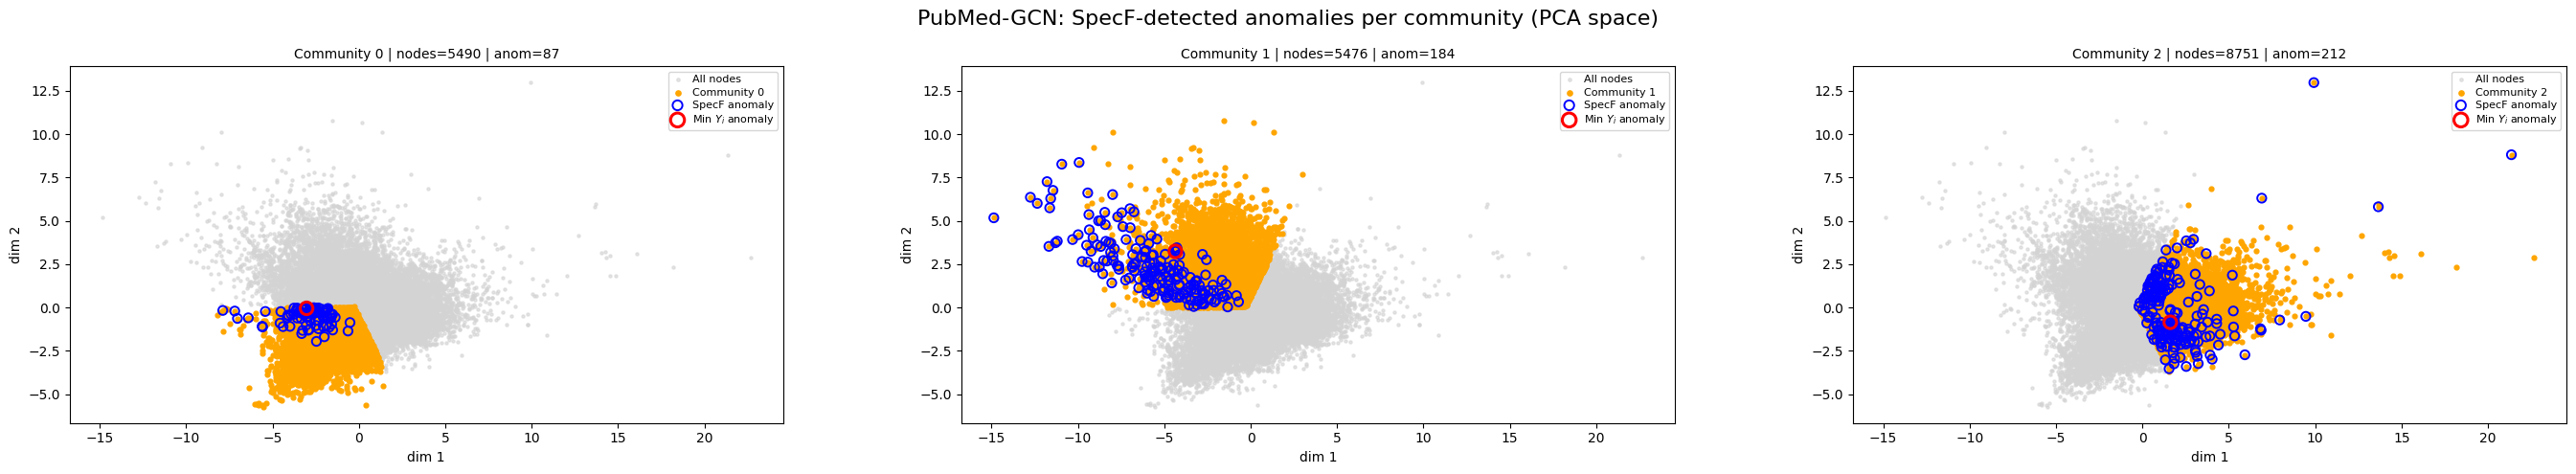

Saved plot to: /content/Results/SpecF_per_community_minYi_highlighted.png


In [34]:
# -------------------------------------------------
# 1. Dataset size (PubMed-safe)
# -------------------------------------------------
N = data.num_nodes

# SpecF anomaly set (node indices)
specf_set = set(map(int, specf_anomalies))

# anomaly mask
mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# -------------------------------------------------
# 2. Community IDs (aligned with data / X2)
# -------------------------------------------------
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# SpecF scores
vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)

# -------------------------------------------------
# 3. Grid layout (single wide figure)
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 9, rows * 5)
)
axes = np.array(axes).reshape(-1)

# -------------------------------------------------
# Results folder
# -------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_per_community_minYi_highlighted.png"

# -------------------------------------------------
# 4. Plot per community
# -------------------------------------------------
for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    mask_comm = (comm_ids == c)
    mask_comm_anom = mask_comm & mask_anom

    # background: all nodes
    ax.scatter(
        X2[:, 0], X2[:, 1],
        s=5, color="lightgray", alpha=0.6,
        label="All nodes"
    )

    # highlight community nodes
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=12, color="orange",
        label=f"Community {c}"
    )

    # anomalies in this community
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0],
            X2[mask_comm_anom, 1],
            s=45,
            facecolors="none",
            edgecolors="blue",
            linewidths=1.4,
            label="SpecF anomaly"
        )

        # -------------------------------------------------
        # Highlight MIN SpecF-score anomaly (RED)
        # -------------------------------------------------
        idx_comm_anom = np.where(mask_comm_anom)[0]
        min_idx = idx_comm_anom[np.argmin(vals_Y[idx_comm_anom])]

        ax.scatter(
            X2[min_idx, 0],
            X2[min_idx, 1],
            s=90,
            facecolors="none",
            edgecolors="red",
            linewidths=2.2,
            label="Min $Y_i$ anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={mask_comm.sum()} | anom={mask_comm_anom.sum()}",
        fontsize=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")

    # -------------------------------------------------
    # Legend (map) per subplot
    # -------------------------------------------------
    ax.legend(
        loc="upper right",
        fontsize=8,
        frameon=True,
        markerscale=1.1,
        handlelength=1.2,
        borderpad=0.3,
        labelspacing=0.3
    )

# -------------------------------------------------
# 5. Remove empty subplots
# -------------------------------------------------
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "PubMed-GCN: SpecF-detected anomalies per community (PCA space)",
    fontsize=16
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# -------------------------------------------------
# 6. Save under Results
# -------------------------------------------------
fig.savefig(out_png, bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

print(f"Saved plot to: {out_png.resolve()}")

# Community-specific localization of SpecF-detected anomalies in PCA space

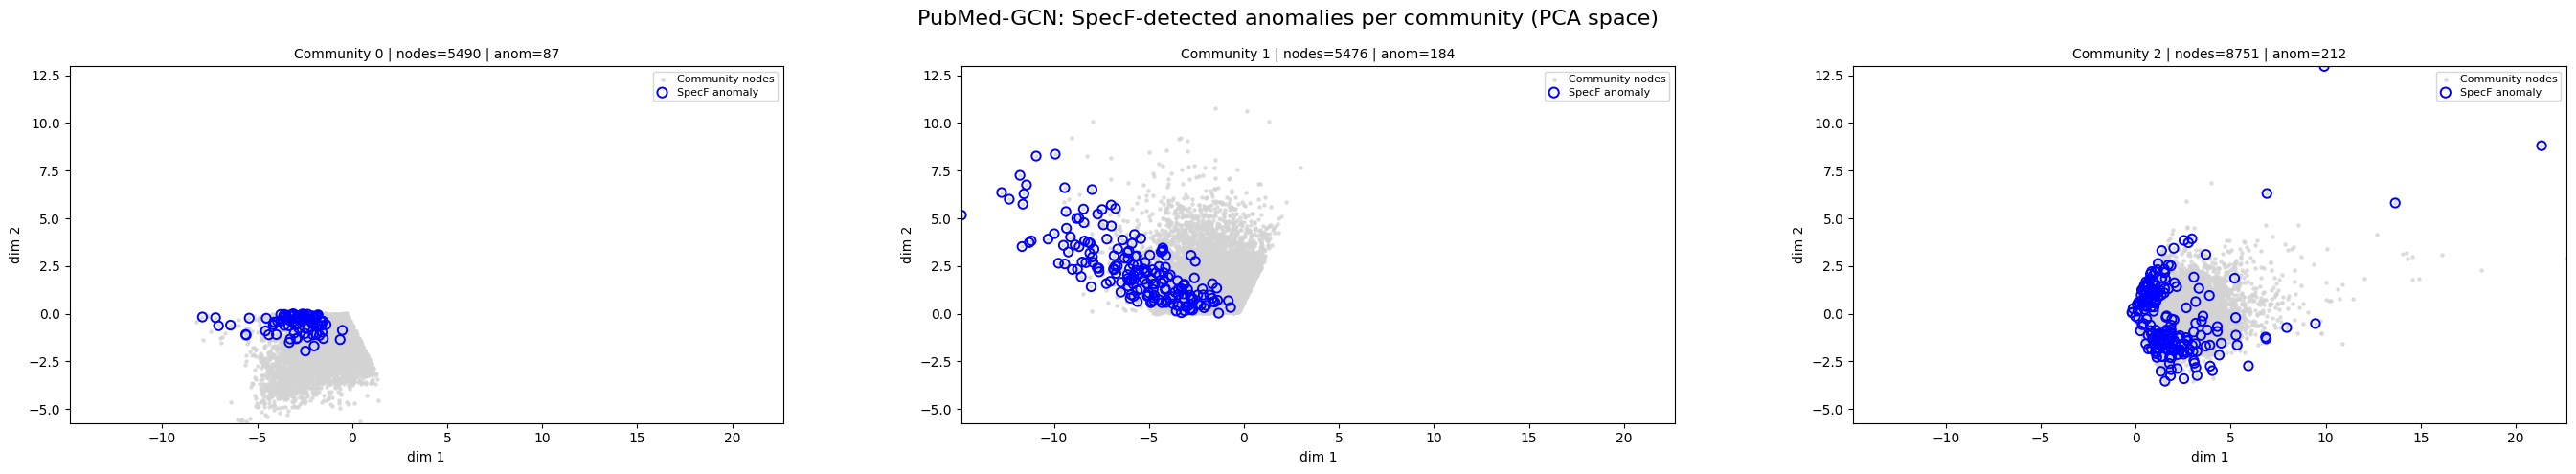

Saved plot to: /content/Results/SpecF_anomalies_per_community_onlyCommunityNodes.png


In [35]:
# -------------------------------------------------
# PubMed-safe sizing and anomaly mask
# -------------------------------------------------
N = data.num_nodes
specf_set = set(map(int, specf_anomalies))

mask_anom = np.zeros(N, dtype=bool)
mask_anom[list(specf_set)] = True

# -------------------------------------------------
# Community id per node (must align with X2: row i == node i)
# -------------------------------------------------
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)
all_comms = np.sort(np.unique(comm_ids))

# -------------------------------------------------
# Keep same axes for all community plots (fair comparison)
# -------------------------------------------------
x_min, x_max = np.min(X2[:, 0]), np.max(X2[:, 0])
y_min, y_max = np.min(X2[:, 1]), np.max(X2[:, 1])

# -------------------------------------------------
# Grid layout in ONE figure
# -------------------------------------------------
cols = 3
rows = math.ceil(len(all_comms) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 9, rows * 5))
axes = np.array(axes).reshape(-1)

for ax_i, c in enumerate(all_comms):
    ax = axes[ax_i]

    mask_comm = (comm_ids == c)
    mask_comm_anom = mask_comm & mask_anom

    # background: ONLY community nodes
    ax.scatter(
        X2[mask_comm, 0], X2[mask_comm, 1],
        s=5, color="lightgray", alpha=0.7,
        label="Community nodes"
    )

    # anomalies inside this community
    if mask_comm_anom.sum() > 0:
        ax.scatter(
            X2[mask_comm_anom, 0], X2[mask_comm_anom, 1],
            s=45, edgecolors="blue", facecolors="none",
            linewidths=1.4, label="SpecF anomaly"
        )

    ax.set_title(
        f"Community {c} | nodes={mask_comm.sum()} | anom={mask_comm_anom.sum()}",
        fontsize=10
    )
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # -------------------------------------------------
    # Legend (map) per subplot
    # -------------------------------------------------
    ax.legend(
        loc="upper right",
        fontsize=8,
        frameon=True,
        markerscale=1.1,
        handlelength=1.2,
        borderpad=0.3,
        labelspacing=0.3
    )

# turn off unused subplots
for j in range(len(all_comms), len(axes)):
    axes[j].axis("off")

fig.suptitle("PubMed-GCN: SpecF-detected anomalies per community (PCA space)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# -------------------------------------------------
# Save under Results
# -------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / "SpecF_anomalies_per_community_onlyCommunityNodes.png"
fig.savefig(out_png, bbox_inches="tight", dpi=300)

plt.show()
plt.close(fig)

print(f"Saved plot to: {out_png.resolve()}")

# dominant subject at all nodes VS dominant subject at anomalous nodes

In [41]:
# -------------------------------------------------
# PubMed class mapping
# -------------------------------------------------
PUBMED_CLASSES = {
    0: "Diabetes Mellitus, Experimental",
    1: "Diabetes Mellitus Type 1",
    2: "Diabetes Mellitus Type 2"
}

# -------------------------------------------------
# Build anomaly mask
# -------------------------------------------------
specf_set = set(map(int, specf_anomalies))  # ok even if empty
df = df_results.copy()
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# -------------------------------------------------
# Attach PubMed class names (your column is label_id)
# -------------------------------------------------
df["class_name"] = df["label_id"].astype(int).map(PUBMED_CLASSES)

# -------------------------------------------------
# Per-community dominant classes (overall vs anomalies)
# -------------------------------------------------
rows = []
for c, g in df.groupby("community_id"):
    cls_all = g["class_name"].value_counts().idxmax()

    g_anom = g[g["is_anom"]]
    if len(g_anom) > 0:
        cls_anom = g_anom["class_name"].value_counts().idxmax()
        anom_count = len(g_anom)
    else:
        cls_anom = "None"
        anom_count = 0

    rows.append({
        "community_id": c,
        "dominant_class_all": cls_all,
        "dominant_class_anom": cls_anom,
        "num_nodes": len(g),
        "num_anomalies": anom_count
    })

df_comm_summary_pubmed = pd.DataFrame(rows).sort_values("community_id")
display(df_comm_summary_pubmed)


,community_id,dominant_class_all,dominant_class_anom,num_nodes,num_anomalies
0,0,"Diabetes Mellitus, Experimental",Diabetes Mellitus Type 1,5490,87
1,1,Diabetes Mellitus Type 1,Diabetes Mellitus Type 1,5476,184
2,2,Diabetes Mellitus Type 2,Diabetes Mellitus Type 2,8751,212


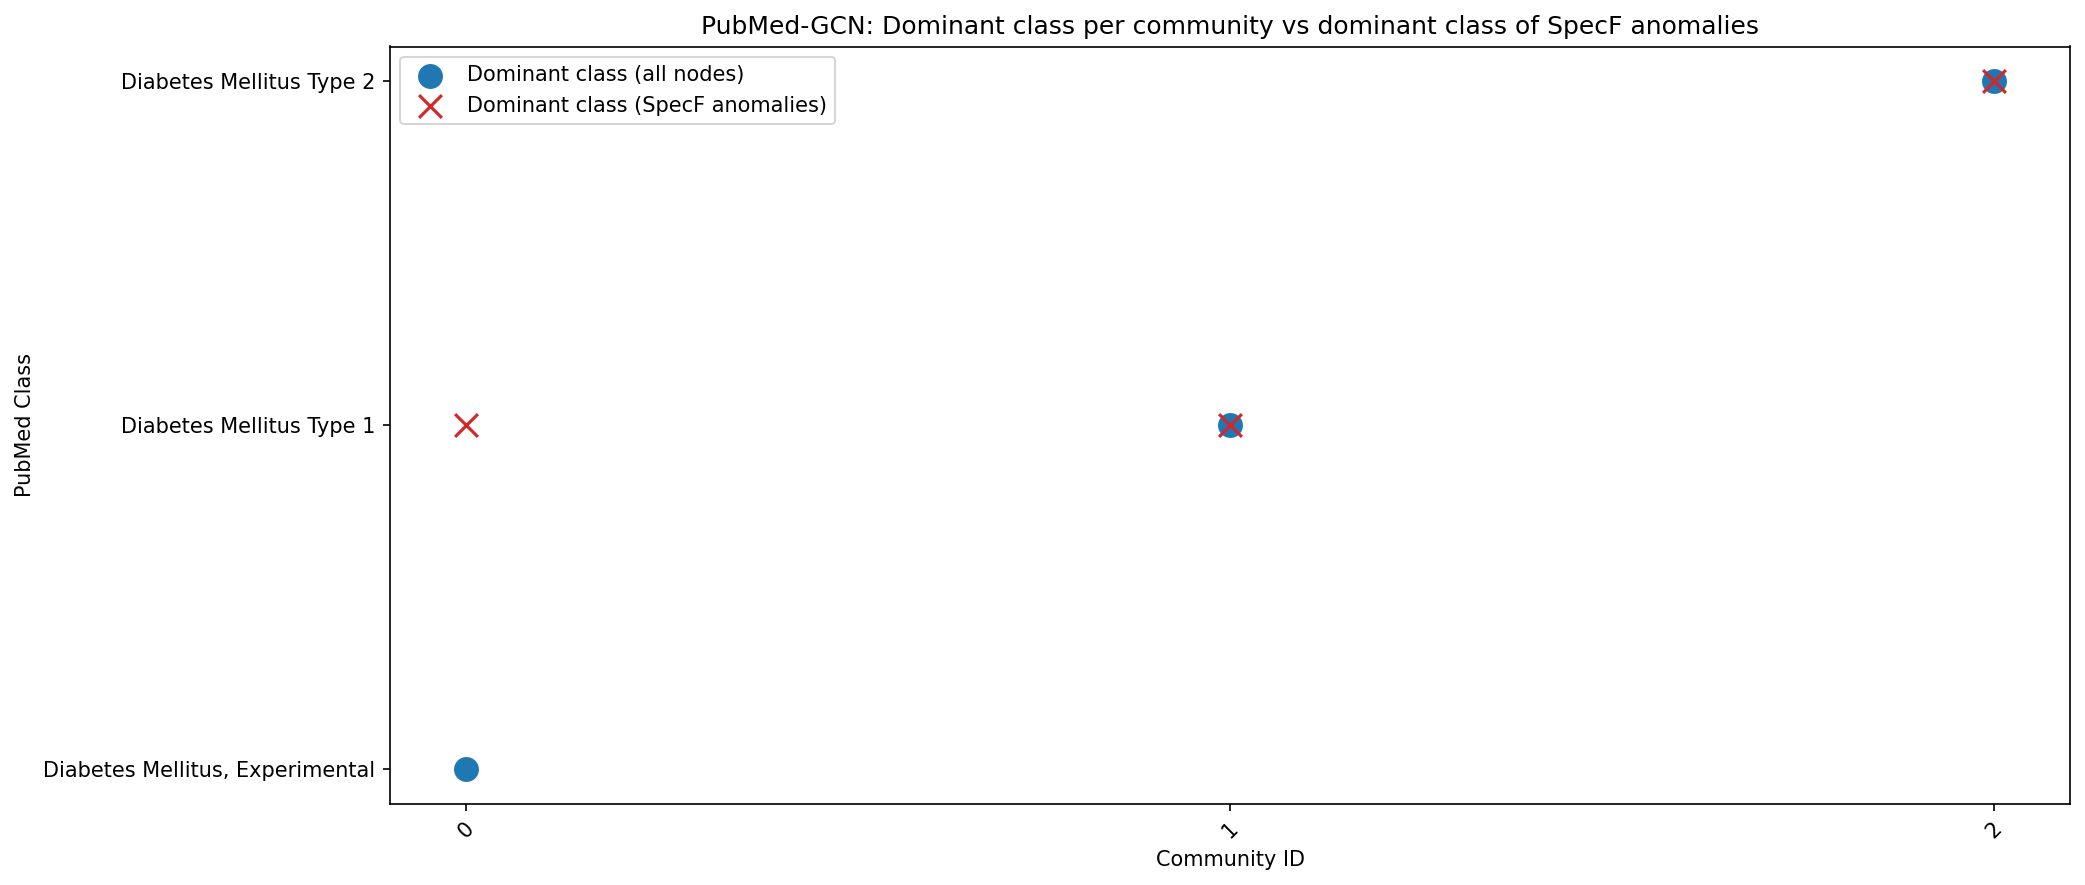

Saved plot to: /content/Results/Dominant_classes_per_community_vs_anomalies_PubMed.png


In [42]:
classes = [PUBMED_CLASSES[i] for i in sorted(PUBMED_CLASSES.keys())]
class_to_id = {c: i for i, c in enumerate(classes)}

# -------------------------------------------------
# Use your PubMed community summary dataframe
# -------------------------------------------------
df_comm_summary = df_comm_summary_pubmed.copy()

df_comm_summary["cls_all_id"] = df_comm_summary["dominant_class_all"].map(class_to_id)
df_comm_summary["cls_anom_id"] = df_comm_summary["dominant_class_anom"].map(
    lambda x: class_to_id[x] if x in class_to_id else -1
)

# -------------------------------------------------
# Save path
# -------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
out_png = RESULTS_DIR / "Dominant_classes_per_community_vs_anomalies_PubMed.png"

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig = plt.figure(figsize=(14, 6), dpi=150)
x = np.arange(len(df_comm_summary))

plt.scatter(
    x,
    df_comm_summary["cls_all_id"],
    s=120,
    label="Dominant class (all nodes)",
    color="tab:blue"
)

plt.scatter(
    x,
    df_comm_summary["cls_anom_id"],
    s=120,
    label="Dominant class (SpecF anomalies)",
    color="tab:red",
    marker="x"
)

plt.xticks(x, df_comm_summary["community_id"], rotation=45)
plt.yticks(np.arange(len(classes)), classes)

plt.xlabel("Community ID")
plt.ylabel("PubMed Class")
plt.title("PubMed-GCN: Dominant class per community vs dominant class of SpecF anomalies")
plt.legend()
plt.tight_layout()

fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved plot to: {out_png.resolve()}")

# min Y value and max Y value per community

In [36]:
N = data.num_nodes

vals_Y = np.array([Y_scores[i] for i in range(N)], dtype=float)
comm_ids = np.array([clusters_dict[i] for i in range(N)], dtype=int)


df_comm_Y = (
    pd.DataFrame({
        "community_id": comm_ids,
        "Y_value": vals_Y
    })
    .groupby("community_id")["Y_value"]
    .agg(
        min_Y="min",
        max_Y="max",
        num_nodes="count"
    )
    .reset_index()
)

df_comm_Y["Y_range"] = df_comm_Y["max_Y"] - df_comm_Y["min_Y"]
display(df_comm_Y)


,community_id,min_Y,max_Y,num_nodes,Y_range
0,0,2633.841444,2.834933e+08,5490,2.834907e+08
1,1,38853.207346,8.981874e+08,5476,8.981486e+08
2,2,74.802445,3.933334e+07,8751,3.933326e+07


# Max Y score in normal node VS min Y score in anomalous node

In [37]:
# --------------------------------------------------
# 1. Build base dataframe
# --------------------------------------------------
df = df_results.copy()

# anomaly mask
specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# attach Y_i score
if isinstance(Y_scores, dict):
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))
else:
    df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# 2. Compute per-community stats
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    # normal nodes
    g_norm = g[~g["is_anom"]]
    # anomalous nodes
    g_anom = g[g["is_anom"]]

    max_normal = g_norm["Y_i"].max() if len(g_norm) > 0 else np.nan
    min_anom   = g_anom["Y_i"].min() if len(g_anom) > 0 else np.nan

    rows.append({
        "community_id": c,
        "num_nodes": len(g),
        "num_normals": len(g_norm),
        "num_anomalies": len(g_anom),
        "max_Y_normal": max_normal,
        "min_Y_anomaly": min_anom,
        "gap_minAnom_minus_maxNorm": (
            min_anom - max_normal
            if not np.isnan(max_normal) and not np.isnan(min_anom)
            else np.nan
        )
    })

# --------------------------------------------------
# 3. Final table
# --------------------------------------------------
df_gap = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

pd.set_option("display.max_colwidth", None)
display(df_gap)


,community_id,num_nodes,num_normals,num_anomalies,max_Y_normal,min_Y_anomaly,gap_minAnom_minus_maxNorm
0,0,5490,5403,87,2.087440e+07,2.137430e+07,4.998987e+05
1,1,5476,5292,184,1.294363e+08,1.305618e+08,1.125490e+06
2,2,8751,8539,212,3.068350e+06,3.073507e+06,5.157328e+03


# min Y value of an anomalous node and max Y value of a normal node per community

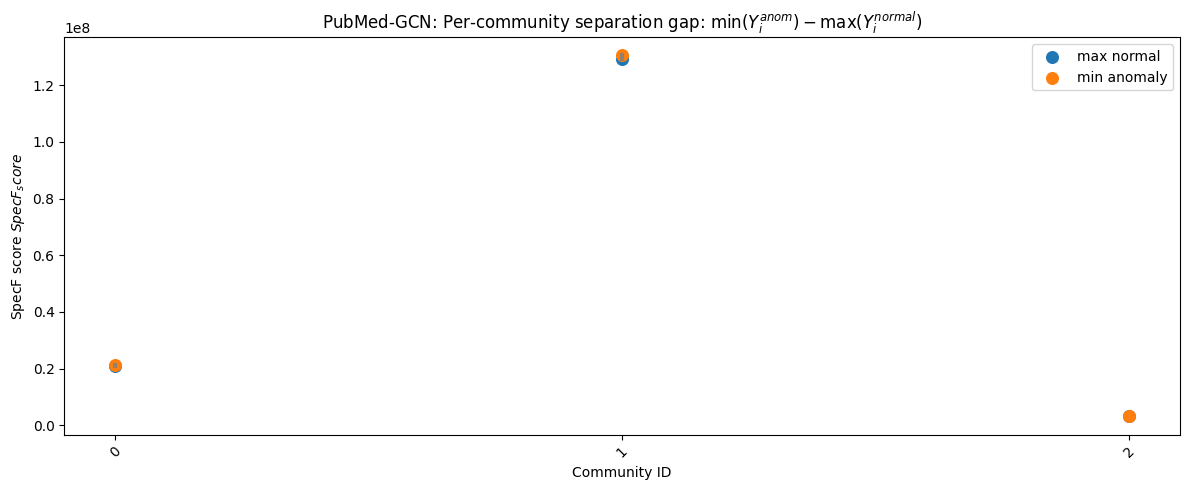

Saved plot to: /content/Results/PubMed_PerCommunity_SeparationGap.png


<Figure size 640x480 with 0 Axes>

In [44]:
df = df_results.copy()

# -----------------------------
# 0) Build anomaly mask (if not already present)
# -----------------------------
if "is_anom" not in df.columns:
    specf_set = set(map(int, specf_anomalies))  # ok even if empty
    df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# -----------------------------
# 1) Validate required columns
# -----------------------------
required_cols = {"community_id", "is_anom"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

# Allow multiple possible score column names
score_col = None
for c in ["Y_i", "SpecF_score", "SpecF_score_Y", "Y_score"]:
    if c in df.columns:
        score_col = c
        break
if score_col is None:
    raise ValueError("df must contain a score column like 'Y_i' or 'SpecF_score'.")

# -----------------------------
# 2) Aggregate per community
#   gap := min(Y_i^{anom}) - max(Y_i^{normal})
# -----------------------------
rows = []
for c, g in df.groupby("community_id"):
    g_norm = g[~g["is_anom"]]
    g_anom = g[g["is_anom"]]

    # skip communities without both types
    if len(g_norm) == 0 or len(g_anom) == 0:
        continue

    max_normal = g_norm[score_col].max()
    min_anom   = g_anom[score_col].min()

    rows.append({
        "community_id": int(c),
        "max_normal": float(max_normal),
        "min_anom": float(min_anom),
        "gap": float(min_anom - max_normal)
    })

comm_gap = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

if comm_gap.empty:
    print("No communities contain BOTH normal and anomaly nodes -> nothing to plot.")
else:
    x = np.arange(len(comm_gap))

    # -----------------------------
    # 3) Plot
    # -----------------------------
    plt.figure(figsize=(12, 5))

    # vertical gap line
    for i, row in comm_gap.iterrows():
        plt.plot([i, i], [row["max_normal"], row["min_anom"]],
                 color="gray", linewidth=3, alpha=0.8)

    # mark max normal & min anomaly
    plt.scatter(x, comm_gap["max_normal"], s=70, label="max normal")
    plt.scatter(x, comm_gap["min_anom"], s=70, label="min anomaly")

    plt.xticks(x, comm_gap["community_id"], rotation=45)
    plt.xlabel("Community ID")
    plt.ylabel(rf"SpecF score ${score_col}$")
    plt.title(r"PubMed-GCN: Per-community separation gap: $\min(Y_i^{anom}) - \max(Y_i^{normal})$")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional save
    RESULTS_DIR = Path("Results")
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    out_png = RESULTS_DIR / "PubMed_PerCommunity_SeparationGap.png"
    plt.gcf().savefig(out_png, bbox_inches="tight", dpi=150)
    print(f"Saved plot to: {out_png.resolve()}")

# Top 5 titles in normal nodes VS top 5 titles in anomalous node

In [38]:
# --------------------------------------------------
# Prepare dataframe
# --------------------------------------------------
df = df_results.copy()

specf_set = set(map(int, specf_anomalies))
df["is_anom"] = df["node_id"].astype(int).isin(specf_set)

# attach Y_i score
df["Y_i"] = df["node_id"].astype(int).map(lambda i: float(Y_scores[int(i)]))

# --------------------------------------------------
# Helper: numbered titles in one cell
# --------------------------------------------------
def numbered_multiline(titles):
    return "\n".join(f"{i+1}. {t}" for i, t in enumerate(titles))

# --------------------------------------------------
# Collect top-5 titles per community
# --------------------------------------------------
rows = []

for c, g in df.groupby("community_id"):
    top_norm = (
        g[~g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    top_anom = (
        g[g["is_anom"]]
        .sort_values("Y_i", ascending=False)
        .head(5)
    )

    rows.append({
        "community_id": c,
        "top5_normal_titles": numbered_multiline(top_norm["title"].tolist()),
        "top5_anomalous_titles": numbered_multiline(top_anom["title"].tolist())
    })

df_top_titles = (
    pd.DataFrame(rows)
    .sort_values("community_id")
    .reset_index(drop=True)
)

# --------------------------------------------------
# Display nicely in notebook (HTML)
# --------------------------------------------------
def newline_to_br(text):
    return text.replace("\n", "<br>") if isinstance(text, str) else text

df_display = df_top_titles.copy()
df_display["top5_normal_titles"] = df_display["top5_normal_titles"].apply(newline_to_br)
df_display["top5_anomalous_titles"] = df_display["top5_anomalous_titles"].apply(newline_to_br)

display(HTML(df_display.to_html(escape=False)))

# --------------------------------------------------
# Export to XLSX under Results/
# --------------------------------------------------
RESULTS_DIR = Path("Results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

output_file = RESULTS_DIR / "PubMed_top5_titles_per_community_GCN.xlsx"
df_top_titles.to_excel(output_file, index=False, engine="openpyxl")

# enable wrap-text in Excel
wb = load_workbook(output_file)
ws = wb.active

wrap = Alignment(wrap_text=True, vertical="top")

headers = [cell.value for cell in ws[1]]
col_norm = headers.index("top5_normal_titles") + 1
col_anom = headers.index("top5_anomalous_titles") + 1

for row in range(2, ws.max_row + 1):
    ws.cell(row=row, column=col_norm).alignment = wrap
    ws.cell(row=row, column=col_anom).alignment = wrap

wb.save(output_file)

print(f"Excel file saved successfully at: {output_file.resolve()}")

,community_id,top5_normal_titles,top5_anomalous_titles
0,0,1. Induction of tolerance to autoimmune diabetes with islet antigens.2. Cachexia in the non-obese diabetic mouse is associated with CD4+ T-cell lymphopenia.3. Prevention of autoimmune diabetes with nonactivating anti-CD3 monoclonal antibody.4. CD8(+) T cell-mediated spontaneous diabetes in neonatal mice.5. Combined gastrin and epidermal growth factor treatment induces islet regeneration and restores normoglycaemia in C57Bl6/J mice treated with alloxan.,"1. Absence of significant Th2 response in diabetes-prone non-obese diabetic (NOD) mice.2. Neonatal tumor necrosis factor alpha promotes diabetes in nonobese diabetic mice by CD154-independent antigen presentation to CD8(+) T cells.3. NF-kappa B prevents beta cell death and autoimmune diabetes in NOD mice.4. A targeted mutation in the IL-4Ralpha gene protects mice against autoimmune diabetes.5. Pancreatic beta cell-specific expression of thioredoxin, an antioxidative and antiapoptotic protein, prevents autoimmune and streptozotocin-induced diabetes."
1,1,1. Adaptive TGF-beta-dependent regulatory T cells control autoimmune diabetes and are a privileged target of anti-CD3 antibody treatment.2. The role of TNF-alpha in the pathogenesis of type 1 diabetes in the nonobese diabetic mouse: analysis of dendritic cell maturation.3. T-cell clones from a type-1 diabetes patient respond to insulin secretory granule proteins.4. The natural killer T lymphocyte: a player in the complex regulation of autoimmune diabetes in non-obese diabetic mice.5. Autoreactive CD8 T cells associated with beta cell destruction in type 1 diabetes.,1. Checkpoints in the progression of autoimmune disease: lessons from diabetes models.2. In autoimmune diabetes the transition from benign to pernicious insulitis requires an islet cell response to tumor necrosis factor alpha.3. Initiation of autoimmune diabetes by developmentally regulated presentation of islet cell antigens in the pancreatic lymph nodes.4. Following a diabetogenic T cell from genesis through pathogenesis.5. Reduced incidence and delayed onset of diabetes in perforin-deficient nonobese diabetic mice.
2,2,"1. Male preponderance in early diagnosed type 2 diabetes is associated with the ARE insertion/deletion polymorphism in the PPP1R3A locus.2. IL2RA/CD25 gene polymorphisms: uneven association with multiple sclerosis (MS) and type 1 diabetes (T1D).3. Association analysis of the IGF1 gene with childhood growth, IGF-1 concentrations and type 1 diabetes.4. Comparison of parametric and nonparametric methods to map oligogenes by linkage.5. Improvement in in vitro insulin action after one month of insulin therapy in obese noninsulin-dependent diabetics. Measurements of glucose transport and metabolism, insulin binding, and lipolysis in isolated adipocytes.","1. Tissue-specific knockout of the insulin receptor in pancreatic beta cells creates an insulin secretory defect similar to that in type 2 diabetes.2. The effect of intensive treatment of diabetes on the development and progression of long-term complications in insulin-dependent diabetes mellitus.3. Construction and validation of the APOCHIP, a spotted oligo-microarray for the study of beta-cell apoptosis.4. The cation efflux transporter ZnT8 (Slc30A8) is a major autoantigen in human type 1 diabetes.5. Development of a novel polygenic model of NIDDM in mice heterozygous for IR and IRS-1 null alleles."


Excel file saved successfully at: /content/Results/PubMed_top5_titles_per_community_GCN.xlsx
